# Will have here a compendium of all the analysis that will make it into chapter 4 of my thesis

In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype
from scipy import stats
import scikit_posthocs as sp

In [171]:
sns.set_context("paper", font_scale=1.6)

In [172]:
df = pd.read_pickle("./data/pre-processed-metrics-dataframe.pkl")

In [4]:
df.scheduler.unique()

array(['DYTAS[navigation=Front,sorting=DFS,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=All,sorting=DFS,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=All,sorting=Khan,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=Front,sorting=DFS,multicore=UseAllCores]',
       'DYTAS[navigation=Front,sorting=Khan,multicore=UseAllCores]',
       'DYTAS[navigation=All,sorting=DFS,multicore=UseAllCores]',
       'DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]', 'HEFT',
       'DLS', 'DynamicList[task=CompSize,resource=Speed,cores=MaxCores]',
       'DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]'],
      dtype=object)

Selecting Only the primary 4 algorithms for my thesis

In [5]:
algorithms = [
    "HEFT",
    "DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]",
    "DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]",
    "DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]"
]

df = df[df.scheduler.isin(algorithms)].reset_index(drop=True)

In [6]:
df.index

RangeIndex(start=0, stop=710208, step=1)

Renaming the algorithms.

In [7]:
rename_map = {
    "HEFT": "HEFT",
    "DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]":"Dynamic List",
    "DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]": "DYTAS",
    "DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]": "Proposed-DYTAS"
}
df["scheduler"] = df.scheduler.map(rename_map)

In [8]:
df.scheduler.unique()

array(['DYTAS', 'Proposed-DYTAS', 'HEFT', 'Dynamic List'], dtype=object)

Making a consistent color map for each of them

In [9]:
cmap = {
    "HEFT":"#49c8d8",
    "Dynamic List":"#cf5b5b",
    "DYTAS":"#88d58b",
    "Proposed-DYTAS":"#cfa65b",
}
hue_order = list(cmap.keys())

# Descriptive Overview

# SLR Distribution

In [10]:
df["SLR"].std()

1678.6364444442477

In [11]:
sum(df["makespan"] < 0) # Making sure there are no negative makespans

0

In [12]:
sum(df["makespan"] < 1) # Number of fractional makespan values

317

<Axes: xlabel='SLR'>

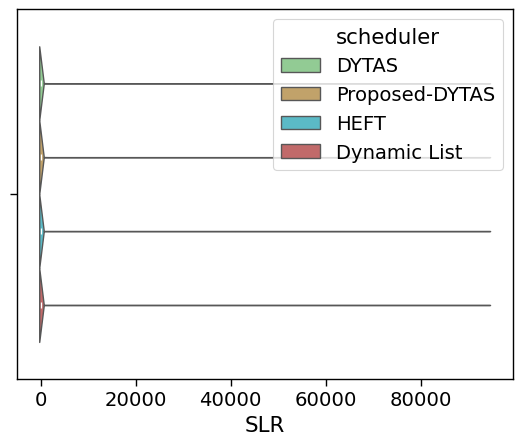

In [13]:
sns.violinplot(data=df, x="SLR", hue="scheduler", palette=cmap)

Values are heavily skewed. For the sake of visualization, the Median Absolute Deviation (MAD) will be used to remove outliers.

In [14]:
def detect_outliers_mad(data, threshold=3.5):
    median = np.median(data)
    mad = np.median(np.abs(data-median))
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    modified_z_scores = 0.6745 * (data - median) / mad
    return np.abs(modified_z_scores) > threshold



In [15]:
df["makespan_outlier"] = df.groupby("scheduler")["makespan"].transform(detect_outliers_mad)

In [16]:
# def outlier_detection_helper(x):
#     outliers = detect_outliers_mad(x["makespan"])

#     return x[~outliers]


# df_mad_makespan = df.groupby("scheduler")[
#     list(df.columns)
# ].apply(outlier_detection_helper).reset_index(drop=True)

In [17]:
# common_test_ids = set(df_mad_makespan[df_mad_makespan['scheduler'] == algorithms[0]]['test_id'])
# print(len(common_test_ids))
# for alg in algorithms[1:]:
#     inst = set(df_mad_makespan[df_mad_makespan['scheduler'] == alg]['test_id'])
#     common_test_ids = common_test_ids.intersection(inst)
#     print(len(common_test_ids))

# df_final = df_mad_makespan[df_mad_makespan['test_id'].isin(common_test_ids)]
# df_final

None of the test instances are the same after outlier removal with MAD method, thus possibly making this an unfair comparison accross the board

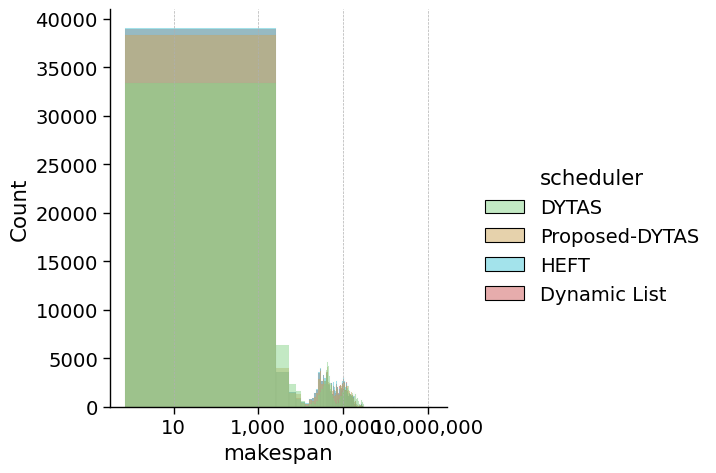

In [18]:
sns.displot(data=df, x="makespan", hue="scheduler", palette=cmap)
plt.xscale("log")  # Compress right tail
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)


This log scale makes it easier to observer why the mayority of the test instances end up with such a low makespan. A more normal distribution can start to be obsertved at around the [10000,300000] range. This slighly alights with how the outliers are removed via the MAD method.

Text(0.5, 1.0, 'Distribution of Makespan per Algorithm (manual range)')

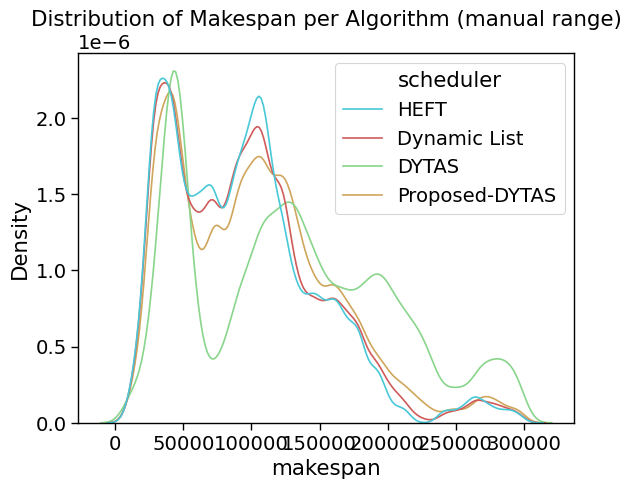

In [19]:
sns.kdeplot(df[(df.makespan >10000)&(df.makespan < 300000)], x='makespan', hue="scheduler",hue_order=hue_order,
               palette=cmap)

plt.title("Distribution of Makespan per Algorithm (manual range)")

Text(0.5, 1.0, 'Distribution of Makespan per Algorithm (manual range)')

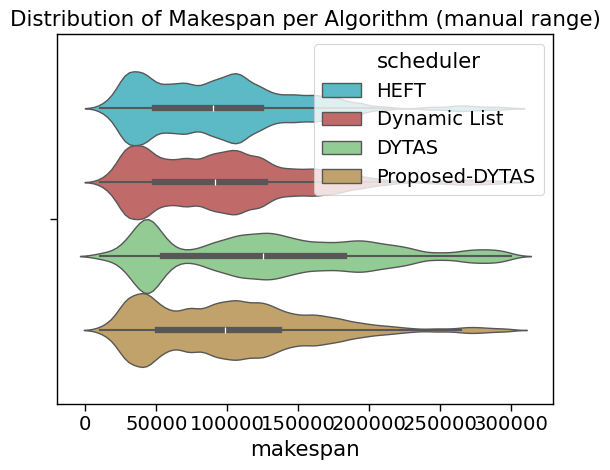

In [20]:
sns.violinplot(df[(df.makespan >10000)&(df.makespan < 300000)], x='makespan', hue="scheduler",hue_order=hue_order,
               palette=cmap)

plt.title("Distribution of Makespan per Algorithm (manual range)")


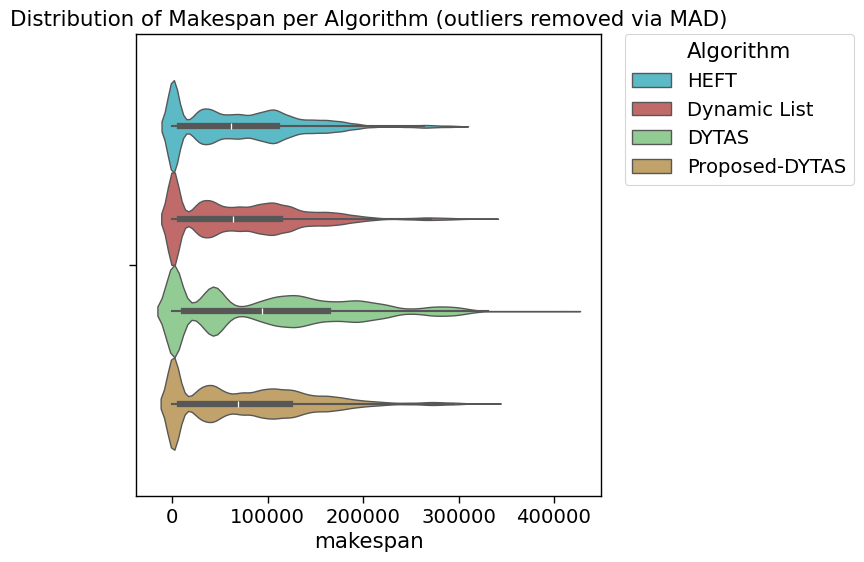

In [21]:
plt.figure(figsize=(6,6))
sns.violinplot(data=df[df.makespan_outlier == False], x="makespan", 
               hue="scheduler", 
               hue_order=hue_order,
               palette=cmap)
plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)
plt.title("Distribution of Makespan per Algorithm (outliers removed via MAD)")
plt.show()

After removing outliers with the mad method for makespan values we can more clearly visualize the distributions. It is easy to see how the medians of HEFT and Dynamic List are close together, with Dynamic List having a higher tail (more extreme values). On the other hand, we see that the median of DYTAS is the highest out of all, and has more extreme values, whilst the Improved version of DYTAS spans a lower median and extremes, which aproximates more how dynamic list is distributed.

## Testing what is impacting outlying results
To make sure it is understood why there exists certain makespan results that are grouped in such a way, and how they differ from the non outlying data.

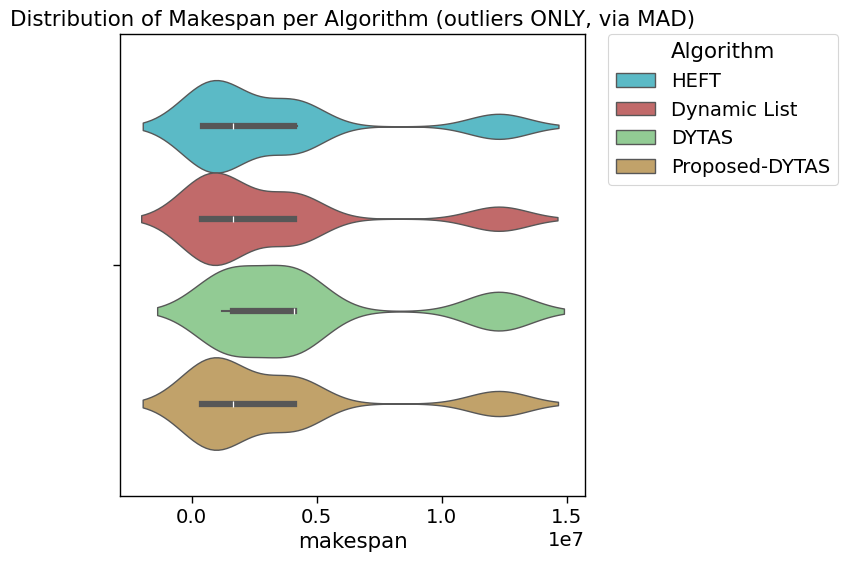

In [22]:
plt.figure(figsize=(6,6))
sns.violinplot(data=df[df.makespan_outlier == True], x="makespan", 
               hue="scheduler", 
               hue_order=hue_order,
               palette=cmap)
plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)
plt.title("Distribution of Makespan per Algorithm (outliers ONLY, via MAD)")
plt.show()

Applying random forest regressor to check what independet variables impact these the most.

In [23]:
# Encoding nominal values
vars_to_encode = ["system_type", "network_model", "workflow"]
encoder = OneHotEncoder(sparse_output=False)

encoded_features = encoder.fit_transform(df[vars_to_encode])
encoded_columns = encoder.get_feature_names_out(vars_to_encode)
df = df.join(pd.DataFrame(encoded_features, columns=encoded_columns))

In [24]:
def random_forest_regressor(df, dependent_var, independent_vars):
    scheduler_col = "scheduler"
    
    # List to store feature importance data
    feature_importance_data = []
    
    # Iterate through each unique scheduler
    for scheduler in df[scheduler_col].unique():
        # Filter data for the current scheduler
        df_scheduler = df[df[scheduler_col] == scheduler]
        
        # Separate independent and dependent variables
        X = df_scheduler[independent_vars]
        y = df_scheduler[dependent_var]
        
        # Train the Regressor
        model = RandomForestRegressor(random_state=0, n_estimators=100)
        model.fit(X, y)
        
        # Extract feature importances
        importances = model.feature_importances_
        
        # Store the results
        for i, imp in enumerate(importances):
            feature_importance_data.append({'Scheduler': scheduler,
                                            'Feature': independent_vars[i],
                                            'Importance': imp})
    
    # Convert to DataFrame for visualization
    importance_df = pd.DataFrame(feature_importance_data)
    
    # Set the figure size
    plt.figure(figsize=(12, 8))
    
    # Create a barplot with dodging to separate bars by scheduler
    sns.barplot(data=importance_df, x='Feature', y='Importance', hue='Scheduler', dodge=True)
    
    # Add labels and title
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance by Scheduler for ' + dependent_var)
    plt.legend(title='Scheduler')
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent clipping of labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [25]:
df.columns

Index(['dag', 'system', 'scheduler', 'makespan', 'exec_time',
       'run_stats.total_task_time', 'run_stats.total_network_traffic',
       'run_stats.total_network_time', 'run_stats.max_used_cores',
       'run_stats.max_cpu_utilization', 'run_stats.cpu_utilization',
       'run_stats.memory_utilization', 'run_stats.used_resource_count',
       'run_stats.cpu_utilization_used', 'run_stats.cpu_utilization_active',
       'dag_nodes', 'dag_edges', 'dag_density', 'dag_total_comp_size',
       'dag_total_transfers_size', 'dag_depth', 'dag_width',
       'dag_parallelism_degree', 'dag_critical_path_size', 'CCR', 'speedup',
       'processor_count', 'core_count', 'efficiency_processors',
       'efficiency_cores', 'network_bandwidth', 'network_latency',
       'network_model', 'min_processor_speed', 'max_processor_speed', 'SLR',
       'workflow', 'test_id', 'system_type', 'makespan_outlier',
       'system_type_heterogeneous', 'system_type_homogeneous',
       'network_model_ConstantBandwi

In [26]:
ind_variables = [
    'dag_nodes', 'dag_density',
    'CCR',
    'processor_count', 'core_count',
    'system_type_heterogeneous', 'system_type_homogeneous',
       'network_model_ConstantBandwidth', 'network_model_SharedBandwidth',
       'workflow_1000genome', 'workflow_blast', 'workflow_bwa',
       'workflow_cycles', 'workflow_epigenomics', 'workflow_montage',
       'workflow_random', 'workflow_seismology', 'workflow_soykb',
       'workflow_srasearch'
]

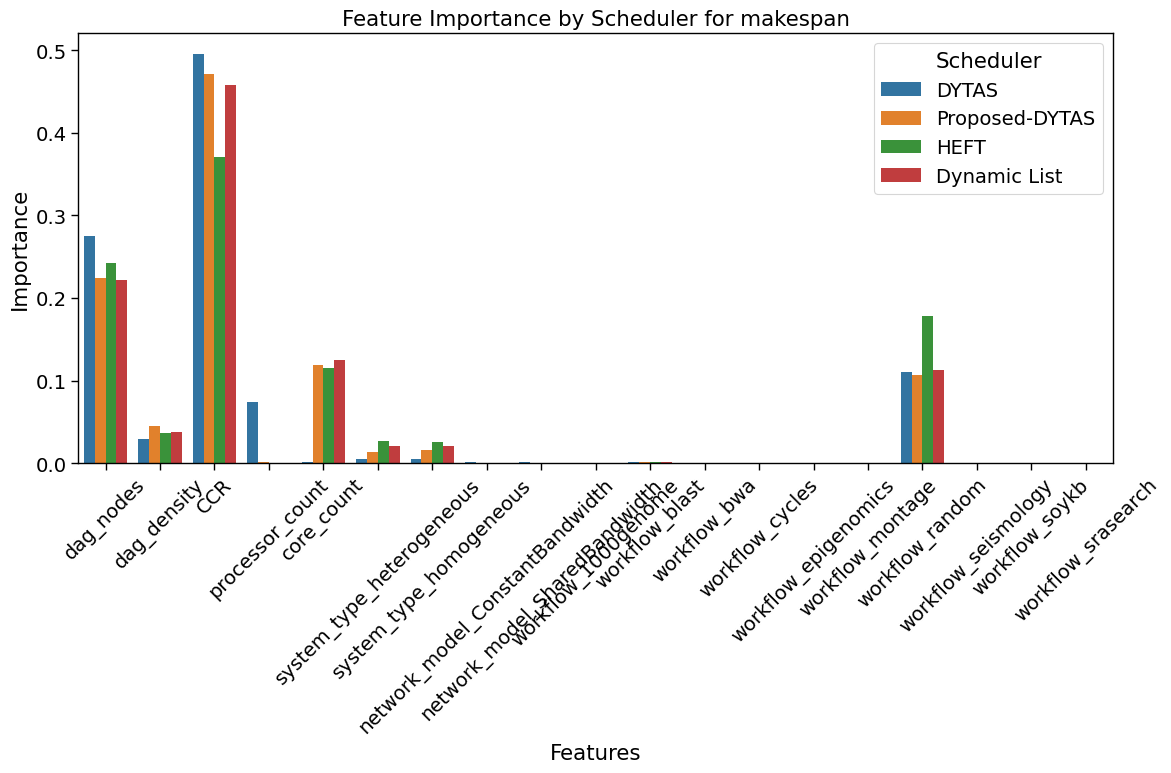

In [27]:
random_forest_regressor(df[df.makespan_outlier == False], "makespan", ind_variables)

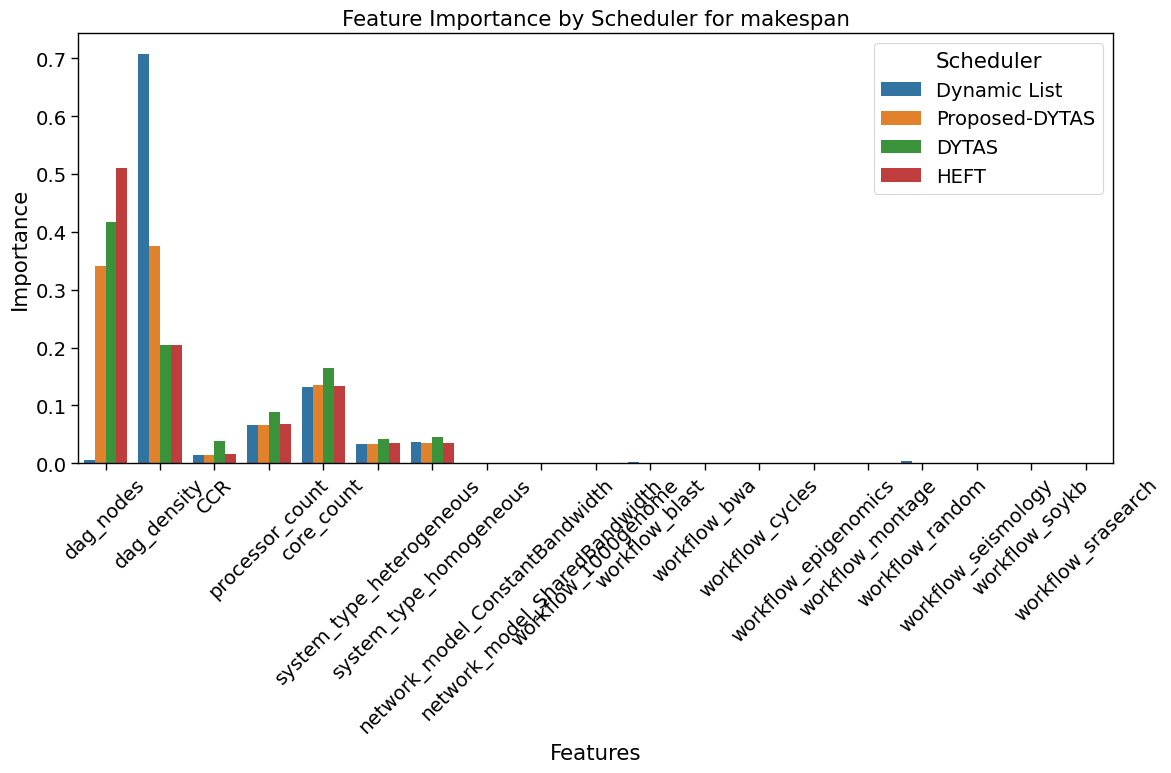

In [28]:
random_forest_regressor(df[df.makespan_outlier == True], "makespan", ind_variables)

The above values suggest that the non outlier values seem to be heavily influenced by the montage workflow. The outliers not, but seem to be more influenced by the density of the DAG.

This suggests to me that it is better to separate these distribution visualizations ber workflow instance, since I know there is a predominance of 400 DAGs that come from DAGGEN that are hevily controlle by their density.

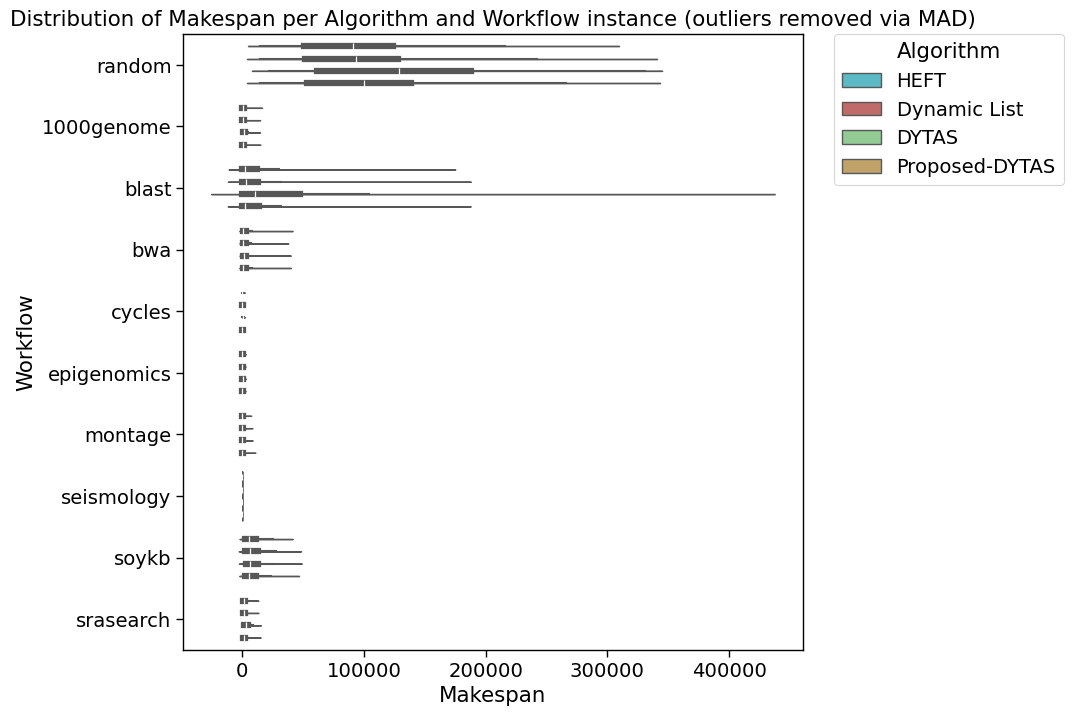

In [29]:
plt.figure(figsize=(8,8))
sns.violinplot(data=df[df.makespan_outlier == False], x="makespan", 
               hue="scheduler",
               y="workflow",
               hue_order=hue_order,
               palette=cmap)
plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)
plt.xlabel("Makespan")
plt.ylabel("Workflow")
plt.title("Distribution of Makespan per Algorithm and Workflow instance (outliers removed via MAD)")
plt.show()

The above graph further confirms that the makespan distribution should be analyzed per workflow/DAG type for better redability.

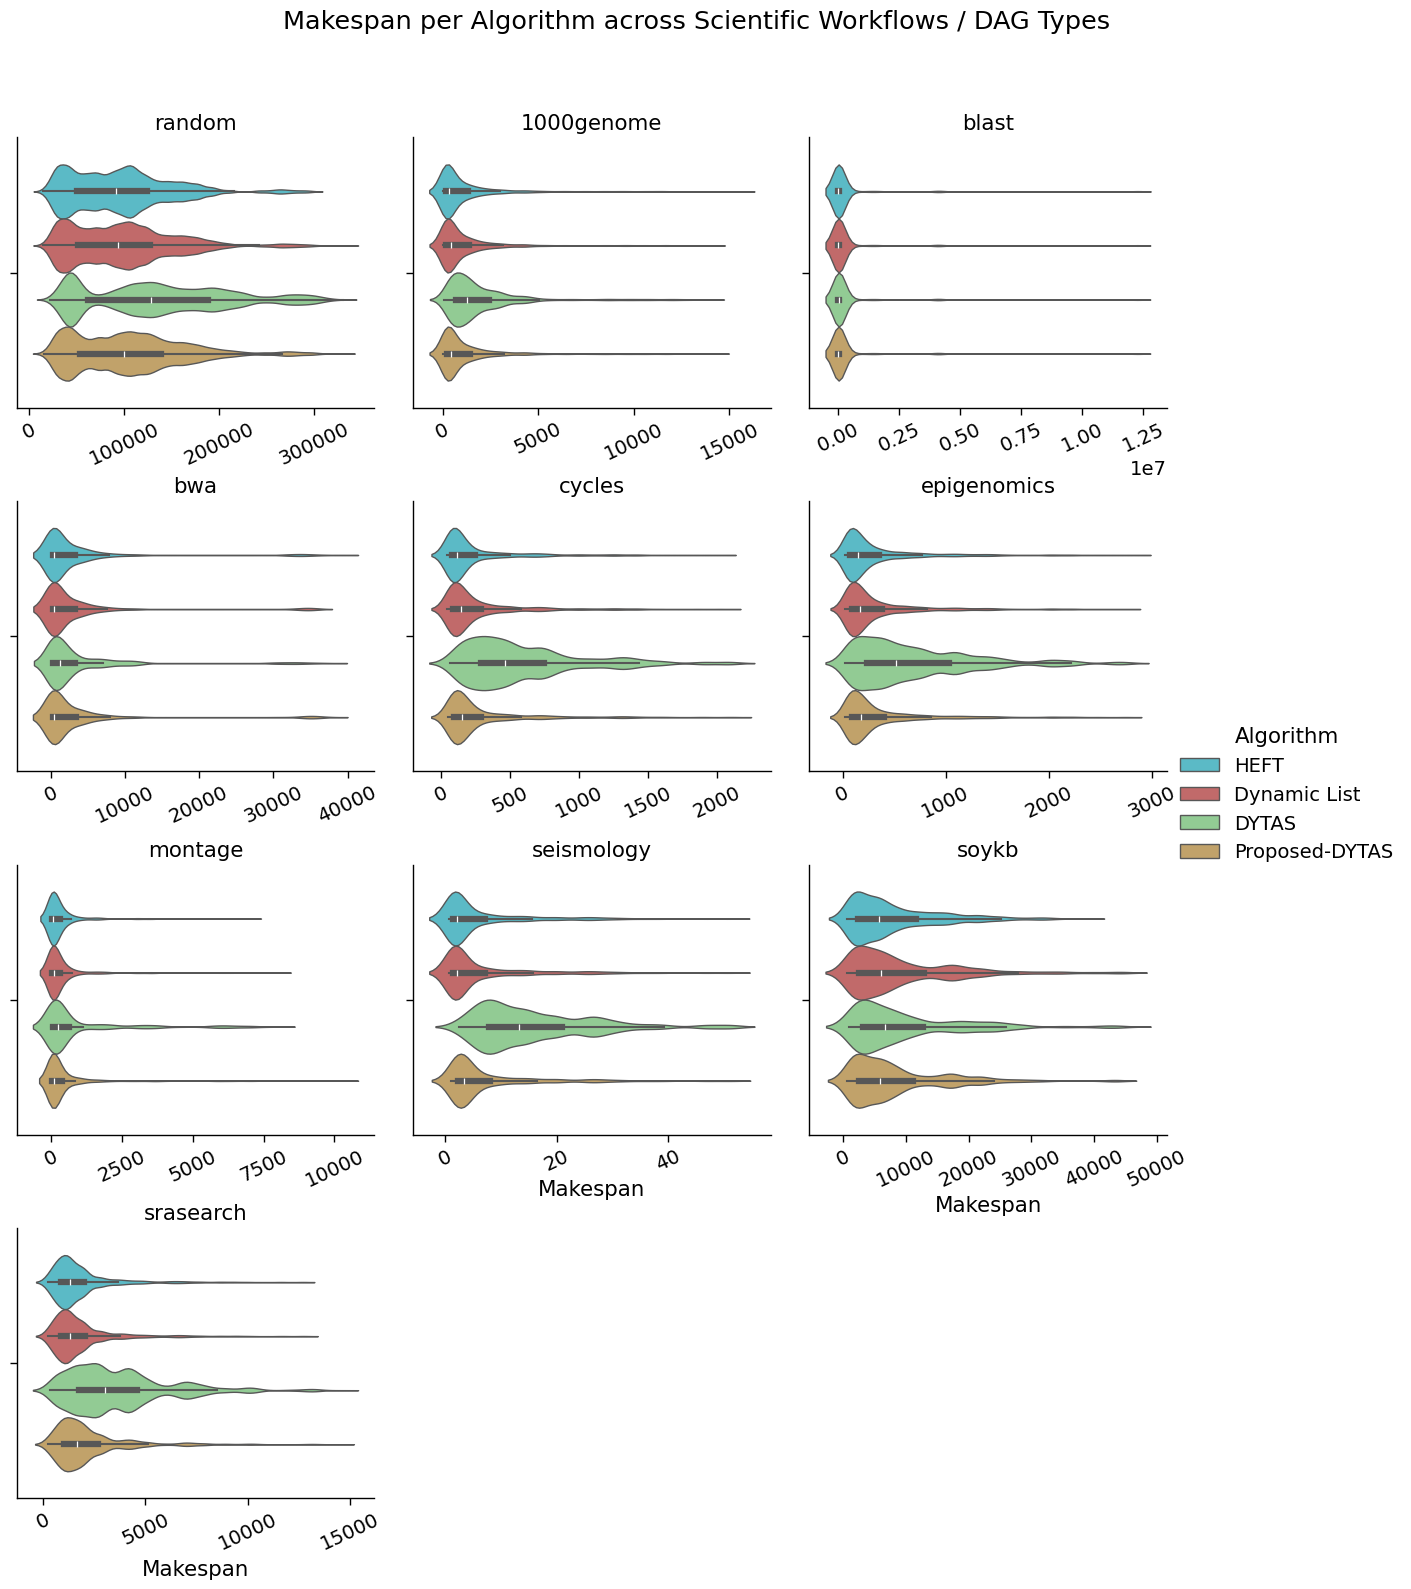

In [30]:

g = sns.FacetGrid(df, col="workflow", col_wrap=3, height=4, sharex=False)
g.map_dataframe(sns.violinplot, x="makespan", hue="scheduler", 
                hue_order=hue_order, palette=cmap, orient='h')

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(25)  # or 45 for more angle

g.add_legend(title="Algorithm")

g.set_axis_labels("Makespan", "")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Makespan per Algorithm across Scientific Workflows / DAG Types")


plt.show()


# Algorithm Speedup

<Axes: xlabel='dag_nodes', ylabel='speedup'>

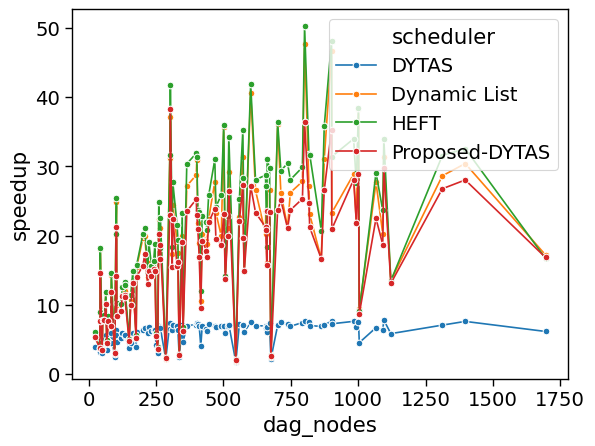

In [31]:
# Calculating the average speedup for pairs of algorithm and nodes


sns.lineplot(
    data=df.groupby(["scheduler", "dag_nodes"])["speedup"].mean().reset_index(),
    y="speedup", x="dag_nodes", hue="scheduler",
    marker='o'
)

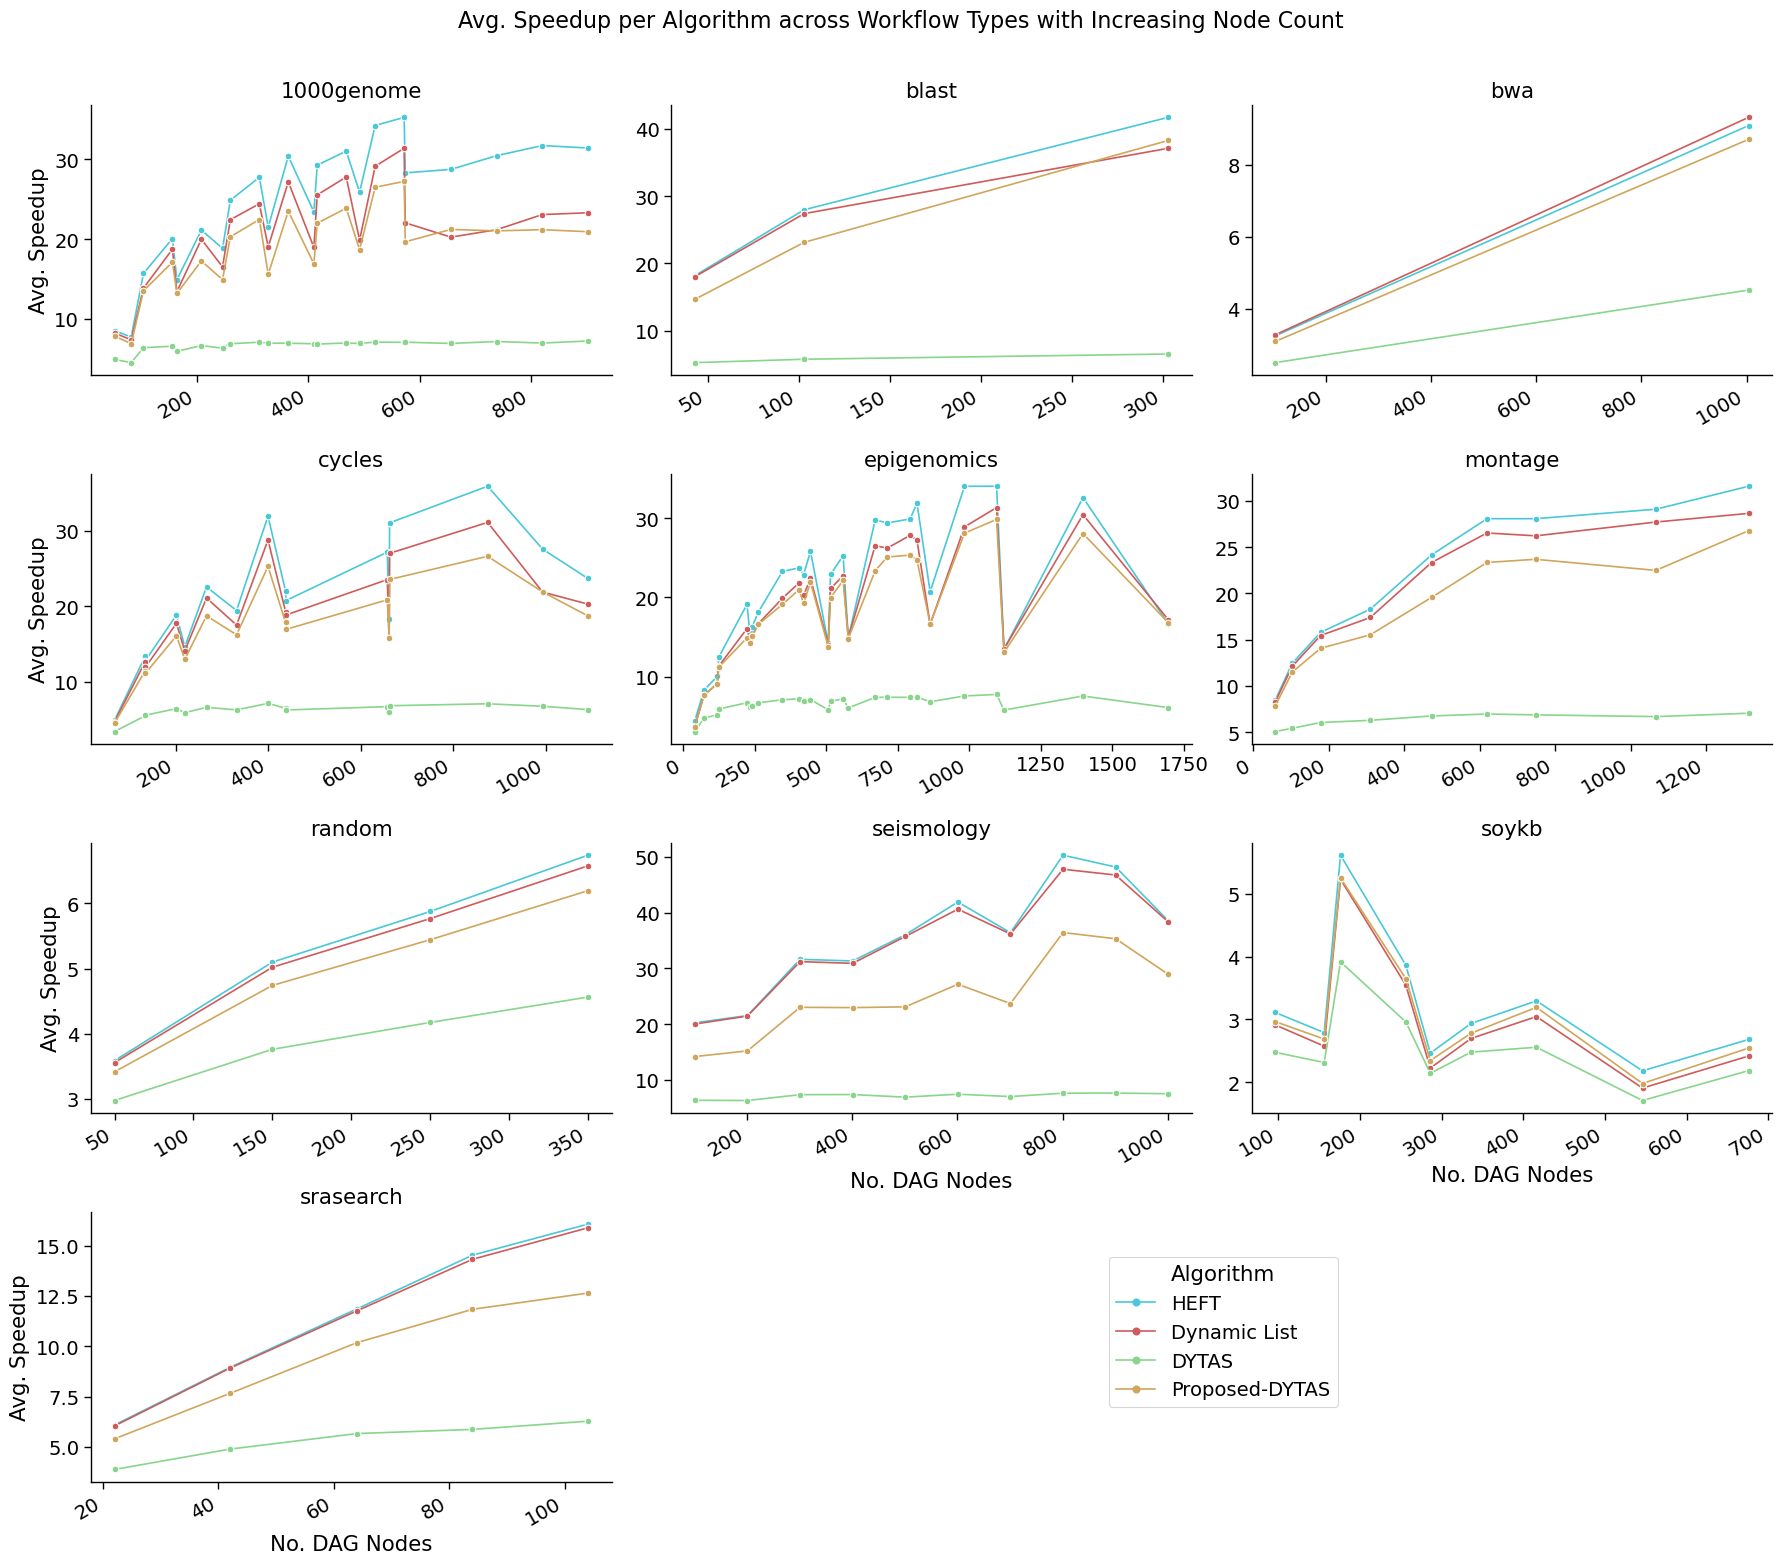

In [32]:
# Prepare the data by grouping and calculating the mean speedup
grouped_df = df.groupby(["workflow", "scheduler", "dag_nodes"])["speedup"].mean().reset_index()

g = sns.relplot(
    data=grouped_df,
    x="dag_nodes",
    y="speedup",
    hue="scheduler",
    kind="line",
    marker="o",
    col="workflow",
    col_wrap=3,
    height=4,
    aspect=1.3,
    hue_order=hue_order, palette=cmap, 
    facet_kws={'sharex': False, 'sharey': False}
)

# Move the legend outside the plot area
sns.move_legend(
    g,
    "lower right",
    bbox_to_anchor=(.75, 0.1),
    frameon=True,
    title="Algorithm"
)

# Adjust layout to accommodate the legend
g.figure.subplots_adjust(right=0.85)

# Set axis labels and titles
g.set_axis_labels("No. DAG Nodes", "Avg. Speedup")
g.set_titles("{col_name}")

# Rotate x-axis tick labels for better readability
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")

# Add a main title to the figure
g.figure.suptitle("Avg. Speedup per Algorithm across Workflow Types with Increasing Node Count", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()



# Algorithm efficiency

In [33]:
figsize=(5,5)

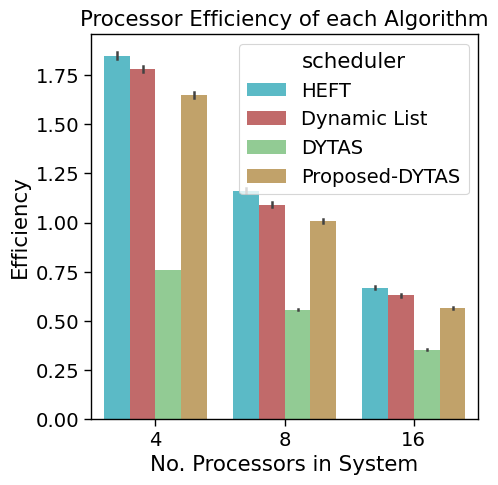

In [34]:

plt.figure(figsize=figsize)
sns.barplot(data=df, x="processor_count", y="efficiency_processors",
            hue="scheduler",hue_order=hue_order, palette=cmap)

plt.title("Processor Efficiency of each Algorithm")
plt.xlabel("No. Processors in System")
plt.ylabel("Efficiency")
plt.show()

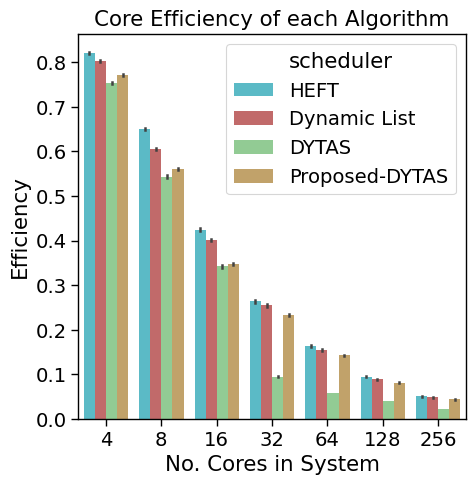

In [35]:

plt.figure(figsize=figsize)
sns.barplot(data=df, x="core_count", y="efficiency_cores", hue="scheduler",
            hue_order=hue_order, palette=cmap)

plt.title("Core Efficiency of each Algorithm")
plt.xlabel("No. Cores in System")
plt.ylabel("Efficiency")
plt.show()

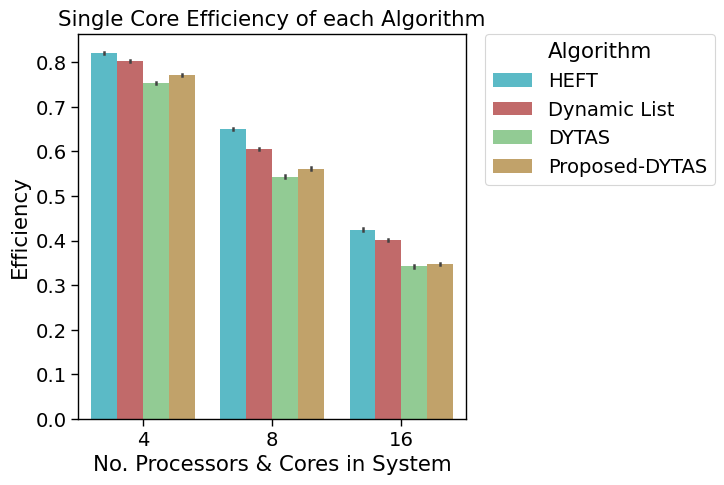

In [36]:
plt.figure(figsize=figsize)
sns.barplot(data=df[df.processor_count == df.core_count], x="processor_count", y="efficiency_processors",
            hue="scheduler",hue_order=hue_order, palette=cmap)

plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)

plt.title("Single Core Efficiency of each Algorithm")
plt.xlabel("No. Processors & Cores in System")
plt.ylabel("Efficiency")
plt.show()

# DAG Density

To visualize if it affects makespan in any way shape or form.

To do this, one must control for node count of the DAG, not just workflow. Otherwise it is difficult to notice the effects of a DAG with the same number of nodes, but just more connections.

In [37]:
df[df.workflow == "random"]["dag_nodes"].unique()

array([150, 250, 350,  50])

In [38]:
# Using node counts that are particular to the
# random DAGs as those had their density controlled.
node_counts = df[df.workflow == "random"]["dag_nodes"].unique()

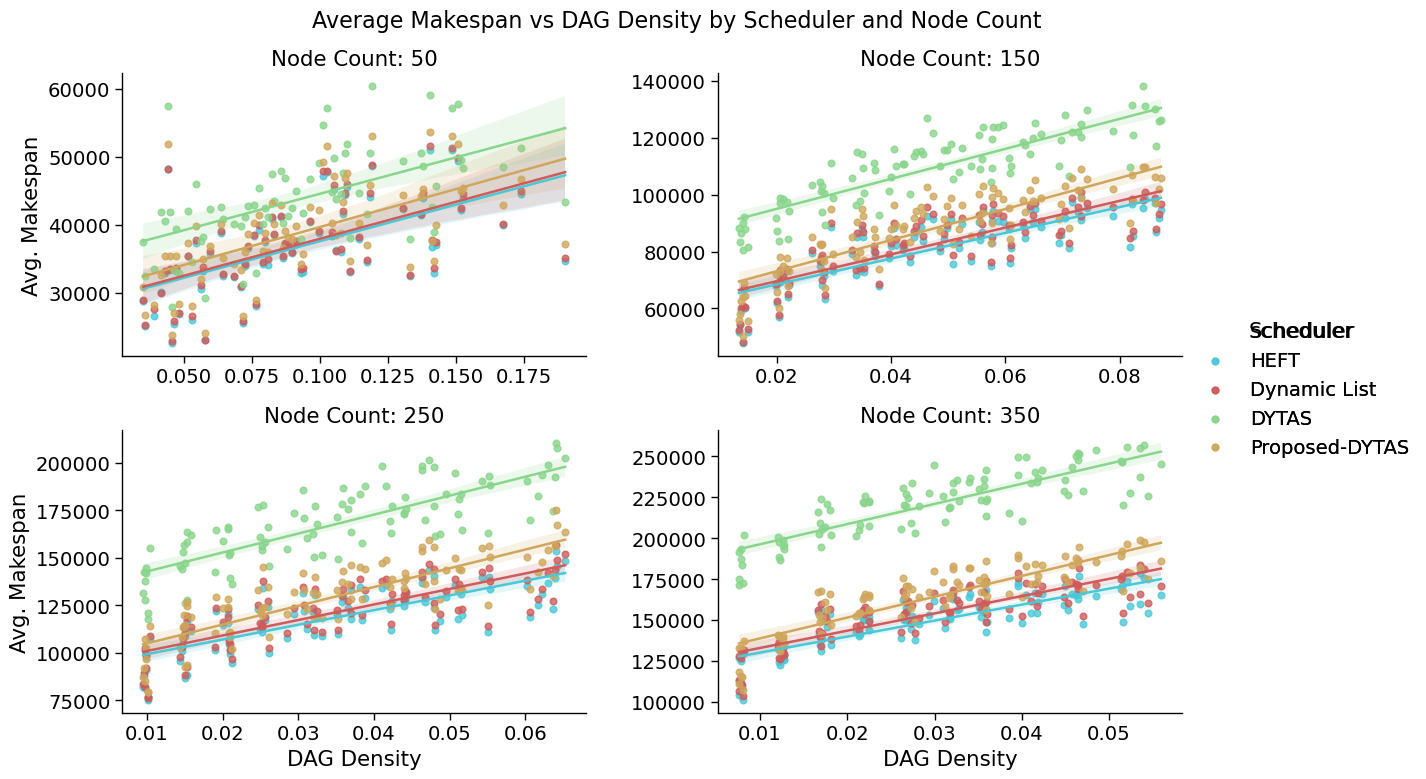

In [39]:
df_grouped = (
    df[df.dag_nodes.isin(node_counts)].groupby(
        ["scheduler", "dag_density", "dag_nodes"])
    ["makespan"]
    .mean()
    .reset_index()
)

# Step 2: Create the lmplot with faceting
g = sns.lmplot(
    data=df_grouped,
    x="dag_density",
    y="makespan",
    hue="scheduler",
    col="dag_nodes",
    col_wrap=2,
    height=4,
    aspect=1.3,
    hue_order=hue_order, palette=cmap,
    facet_kws={"sharex": False, "sharey": False}
)

# Step 3: Customize the plot
g.set_axis_labels("DAG Density", "Avg. Makespan")
g.set_titles("Node Count: {col_name}")
g.add_legend(title="Scheduler")

# Optional: Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average Makespan vs DAG Density by Scheduler and Node Count", fontsize=16)

plt.show()


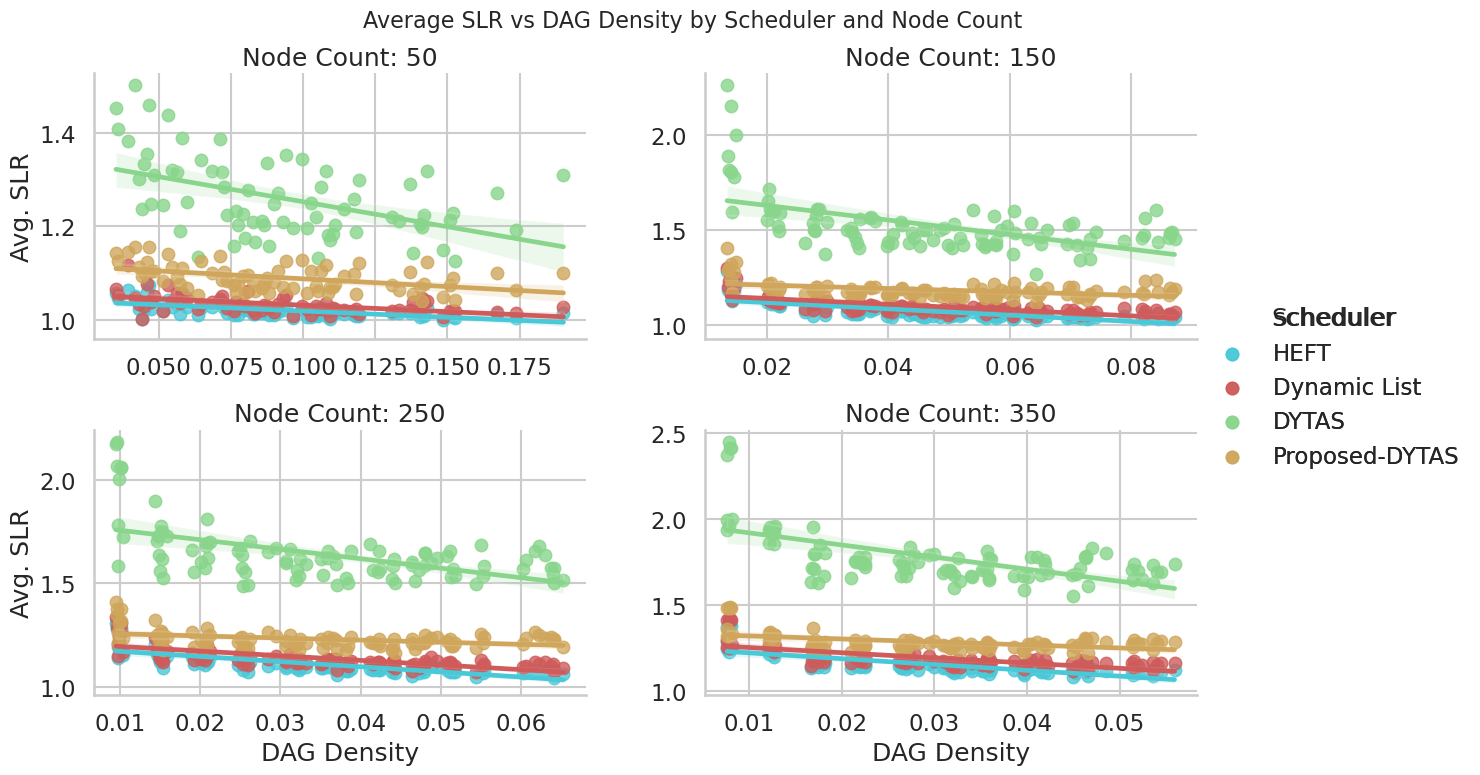

In [60]:
df_grouped = (
    df[df.dag_nodes.isin(node_counts)].groupby(
        ["scheduler", "dag_density", "dag_nodes"])
    ["SLR"]
    .mean()
    .reset_index()
)

# Step 2: Create the lmplot with faceting
g = sns.lmplot(
    data=df_grouped,
    x="dag_density",
    y="SLR",
    hue="scheduler",
    col="dag_nodes",
    col_wrap=2,
    height=4,
    aspect=1.3,
    hue_order=hue_order, palette=cmap,
    facet_kws={"sharex": False, "sharey": False}
)

# Step 3: Customize the plot
g.set_axis_labels("DAG Density", "Avg. SLR")
g.set_titles("Node Count: {col_name}")
g.add_legend(title="Scheduler")

# Optional: Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average SLR vs DAG Density by Scheduler and Node Count", fontsize=16)

plt.show()

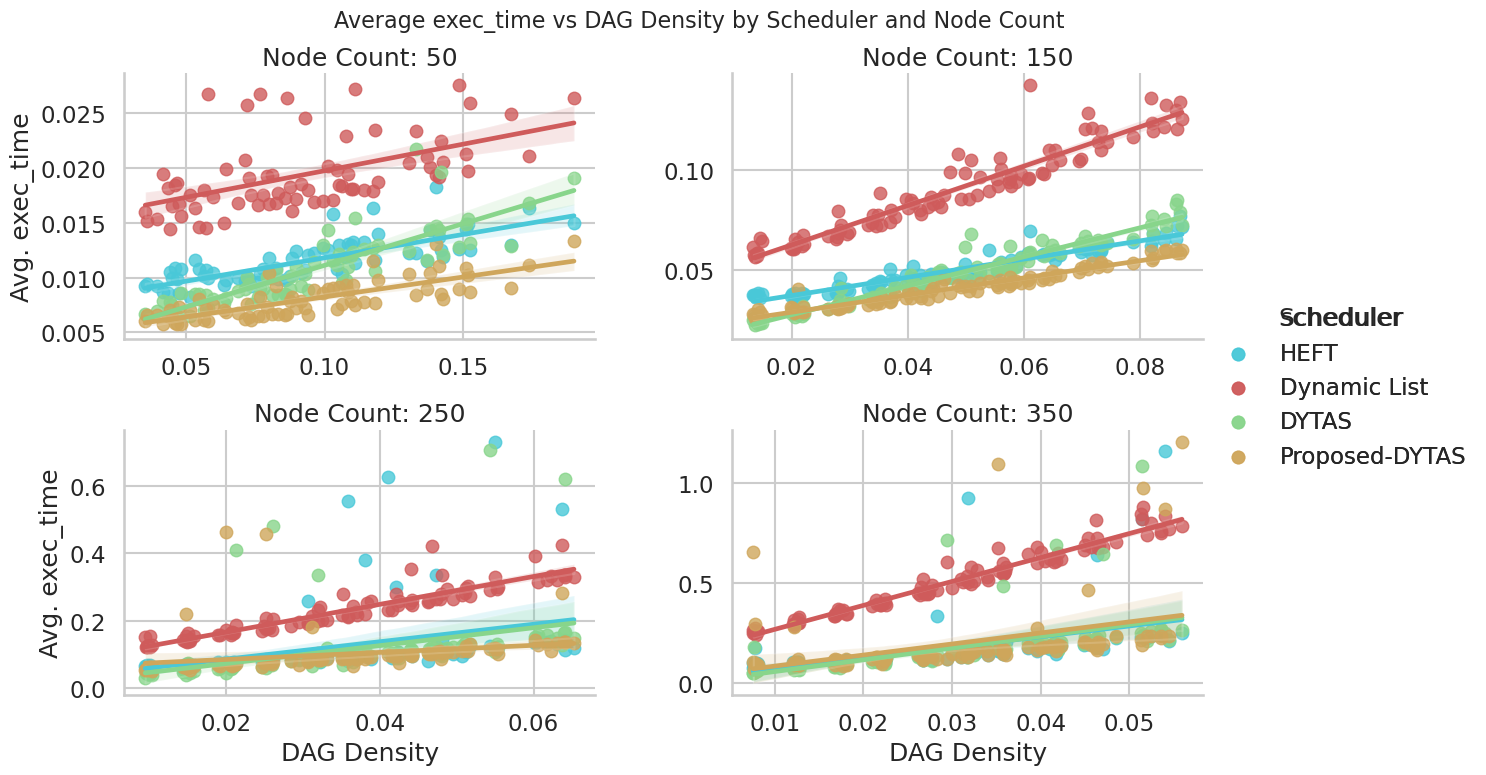

In [61]:
df_grouped = (
    df[df.dag_nodes.isin(node_counts)].groupby(
        ["scheduler", "dag_density", "dag_nodes"])
    ["exec_time"]
    .mean()
    .reset_index()
)

# Step 2: Create the lmplot with faceting
g = sns.lmplot(
    data=df_grouped,
    x="dag_density",
    y="exec_time",
    hue="scheduler",
    col="dag_nodes",
    col_wrap=2,
    height=4,
    aspect=1.3,
    hue_order=hue_order, palette=cmap,
    facet_kws={"sharex": False, "sharey": False}
)

# Step 3: Customize the plot
g.set_axis_labels("DAG Density", "Avg. exec_time")
g.set_titles("Node Count: {col_name}")
g.add_legend(title="Scheduler")

# Optional: Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average exec_time vs DAG Density by Scheduler and Node Count", fontsize=16)

plt.show()

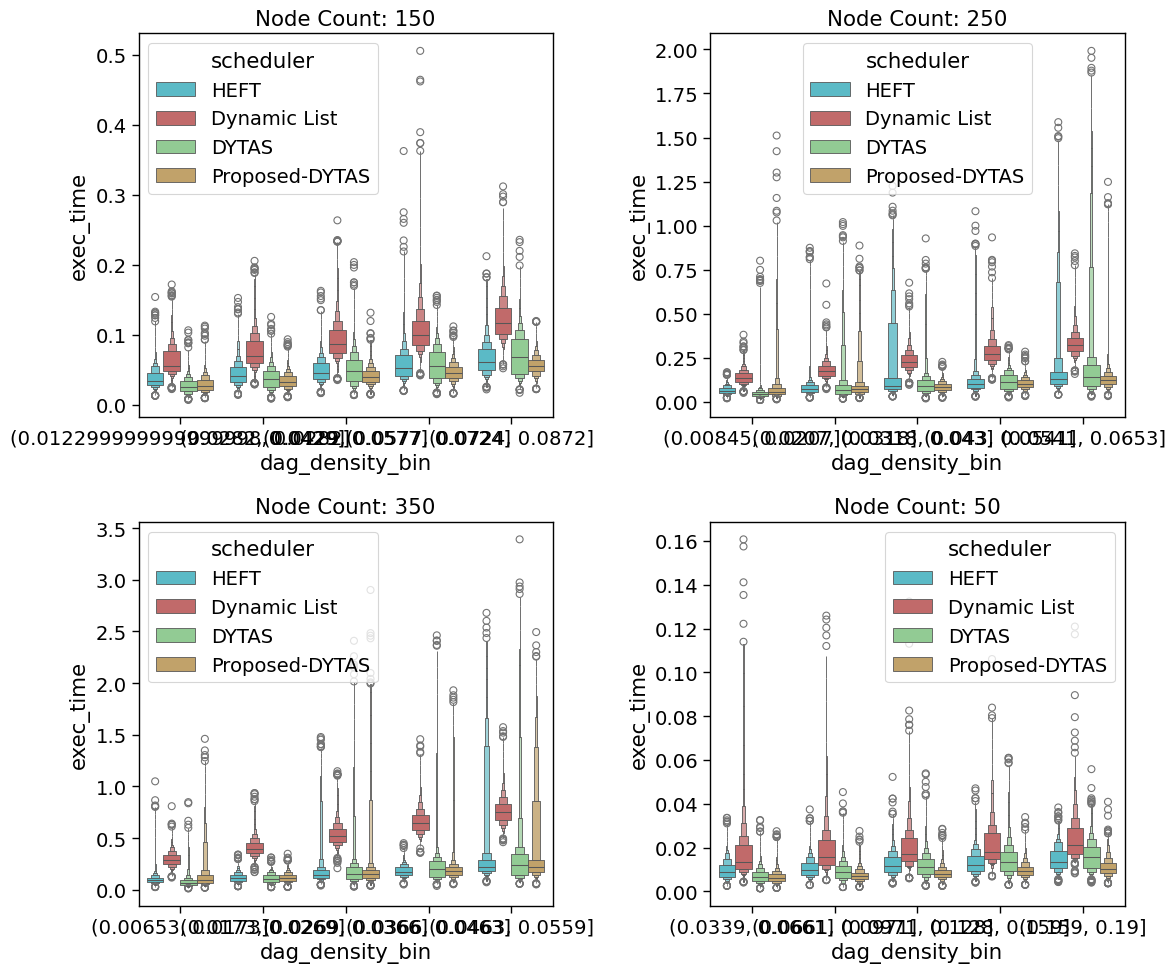

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, node_count in zip(axes.flatten(), node_counts):
    data = df[(df.dag_nodes == node_count)].copy()
    data["dag_density_bin"] = pd.cut(data["dag_density"], 5, include_lowest=True)
    sns.boxenplot(
        data=data,
        x="dag_density_bin", y="exec_time", hue="scheduler",
        dodge=True, ax=ax,
        hue_order=hue_order, palette=cmap,
    ).set(title="Node Count: " + str(node_count))
    
plt.tight_layout()
plt.show()

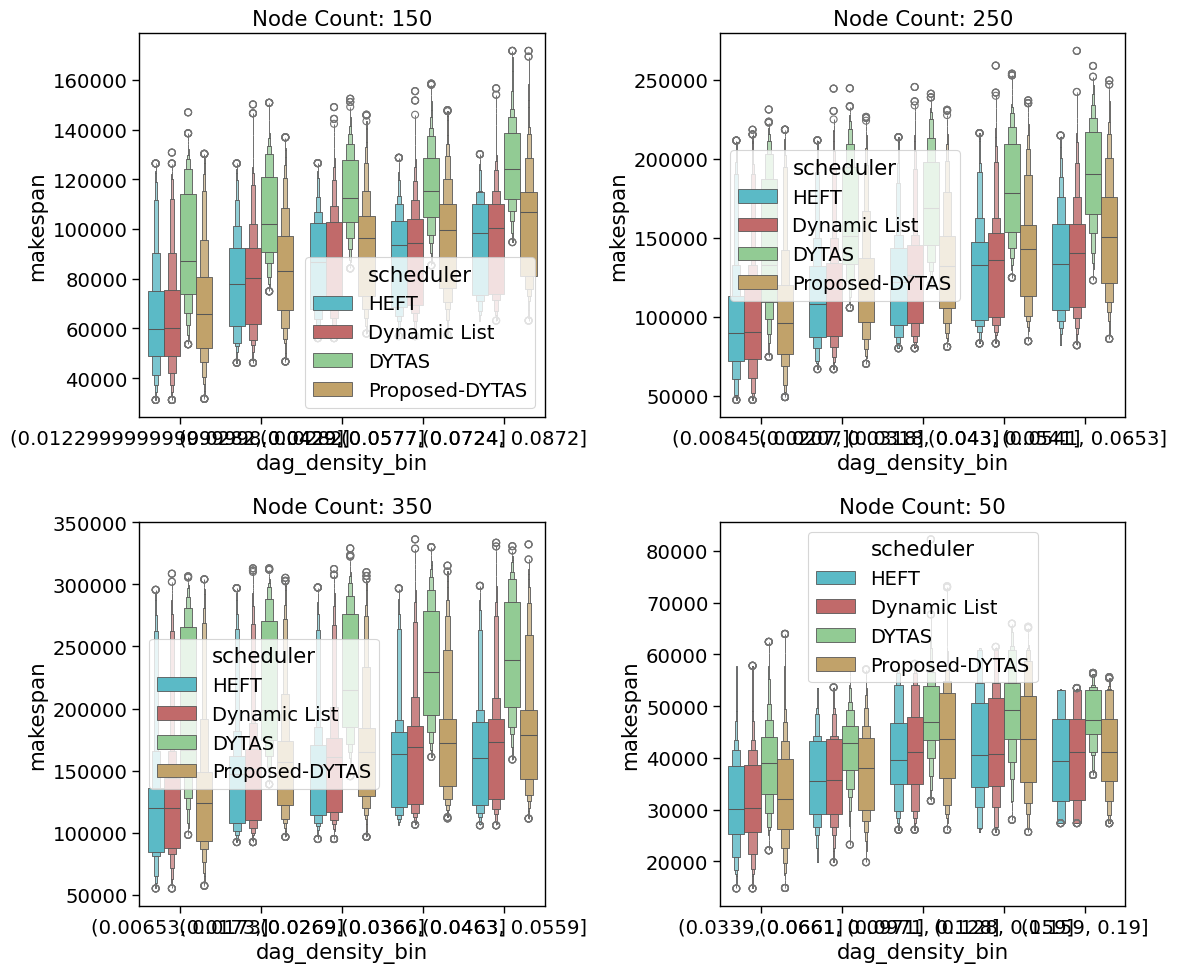

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, node_count in zip(axes.flatten(), node_counts):
    data = df[(df.dag_nodes == node_count)].copy()
    data["dag_density_bin"] = pd.cut(data["dag_density"], 5, include_lowest=True)
    sns.boxenplot(
        data=data,
        x="dag_density_bin", y="makespan", hue="scheduler",
        dodge=True, ax=ax,
        hue_order=hue_order, palette=cmap,
    ).set(title="Node Count: " + str(node_count))
    
plt.tight_layout()
plt.show()

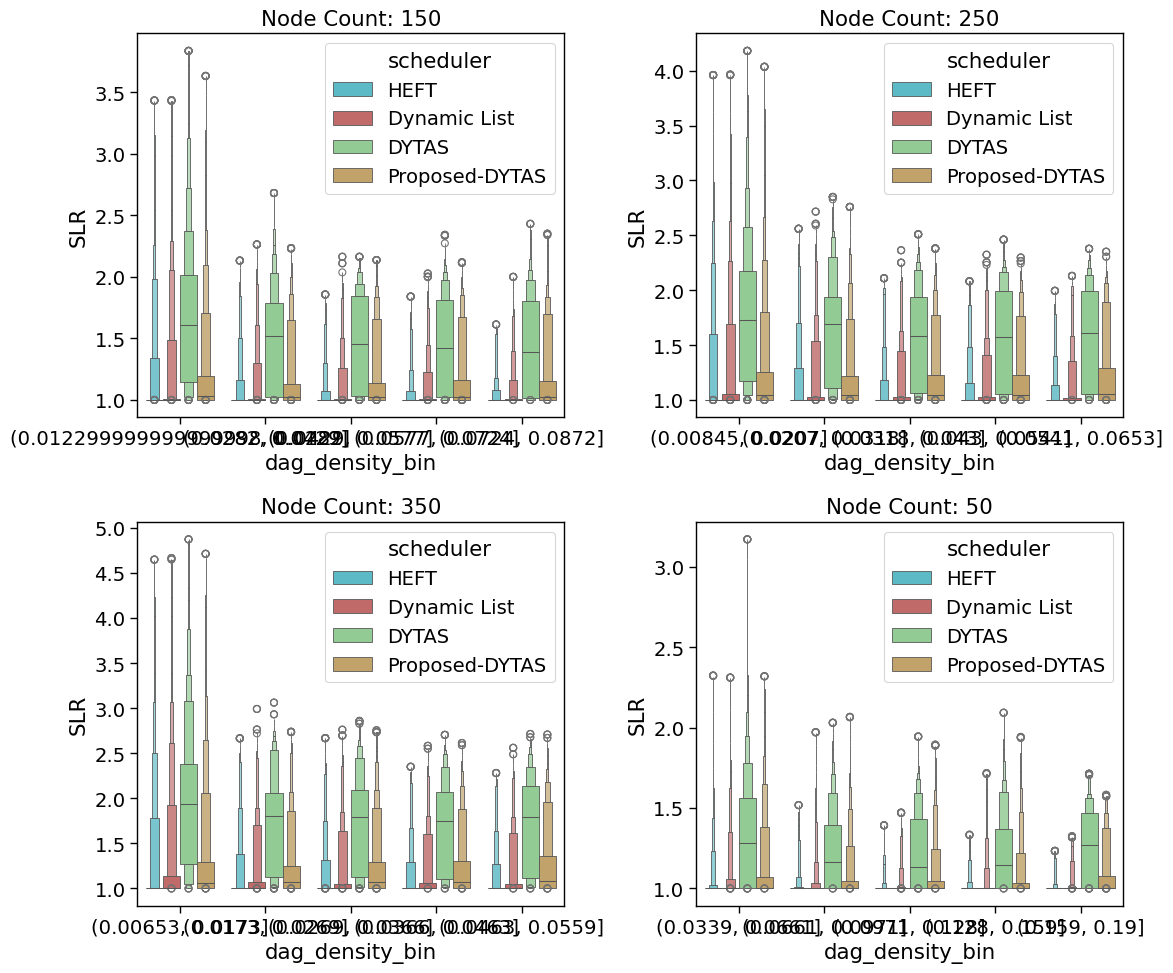

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, node_count in zip(axes.flatten(), node_counts):
    data = df[(df.dag_nodes == node_count)].copy()
    data["dag_density_bin"] = pd.cut(data["dag_density"], 5, include_lowest=True)
    sns.boxenplot(
        data=data,
        x="dag_density_bin", y="SLR", hue="scheduler",
        dodge=True, ax=ax,
        hue_order=hue_order, palette=cmap,
    ).set(title="Node Count: " + str(node_count))
    
plt.tight_layout()
plt.show()

# Communication to Computation Ratio

Remember that the smaller the CCR, the more computationally heavy the DAG is wrt to its data, whilst the larger the value the more data havy the DAG is wrt to its computational requirements.

<Axes: xlabel='CCR', ylabel='Density'>

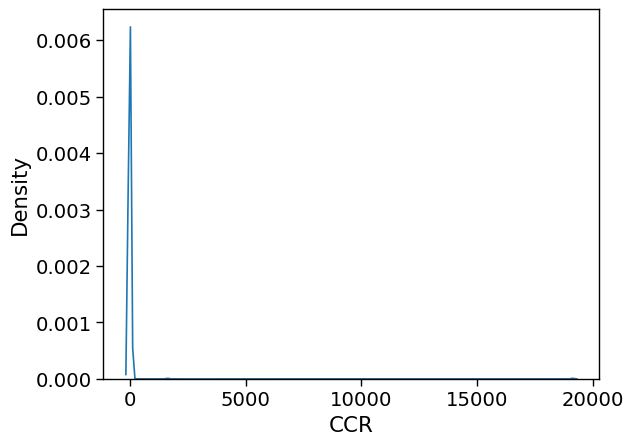

In [43]:
sns.kdeplot(df.CCR)

<Axes: xlabel='CCR', ylabel='Density'>

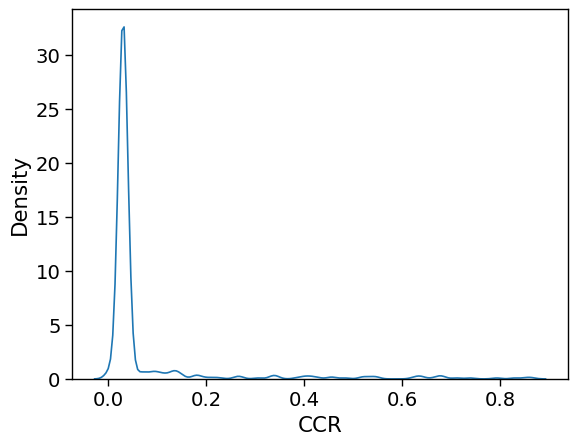

In [44]:
sns.kdeplot(df[df["CCR"] < 1].CCR)

In [45]:
df[df.CCR <1].workflow.unique()

array(['random', 'blast', 'cycles', 'epigenomics', 'montage',
       'seismology', 'srasearch'], dtype=object)

<Axes: xlabel='CCR', ylabel='Density'>

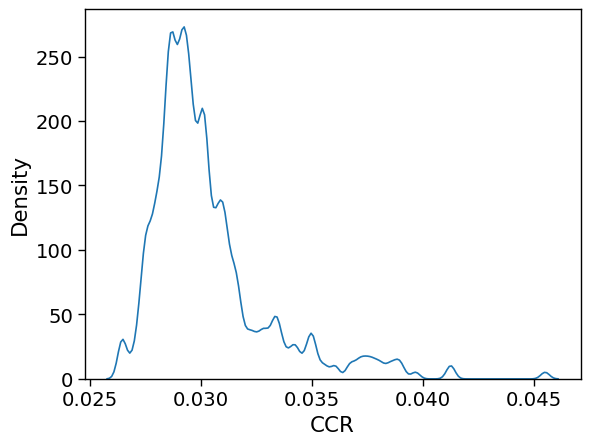

In [46]:
sns.kdeplot(df[df.workflow == "random"].CCR)

In [47]:
df[df.workflow == "random"].CCR.min()

0.026339104828535156

In [48]:
df[df.workflow == "random"].CCR.max()

0.04552315870218475

In [49]:
len(df[df.workflow == "random"].CCR)

518400

I believe that for this particular analysis it would be ideal to only use the random dags...

<Axes: xlabel='CCR', ylabel='Density'>

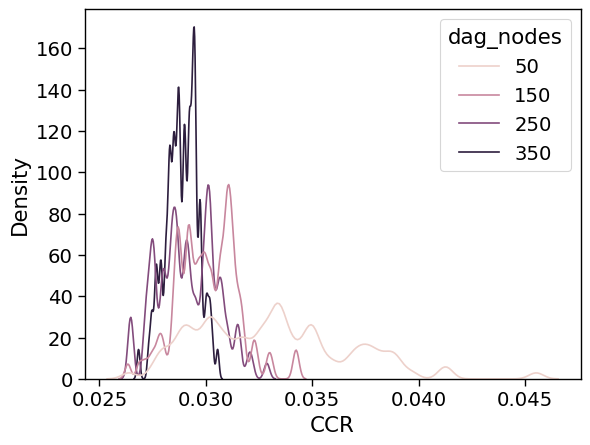

In [51]:
sns.kdeplot(df[(df.workflow=="random")], x="CCR", hue="dag_nodes")

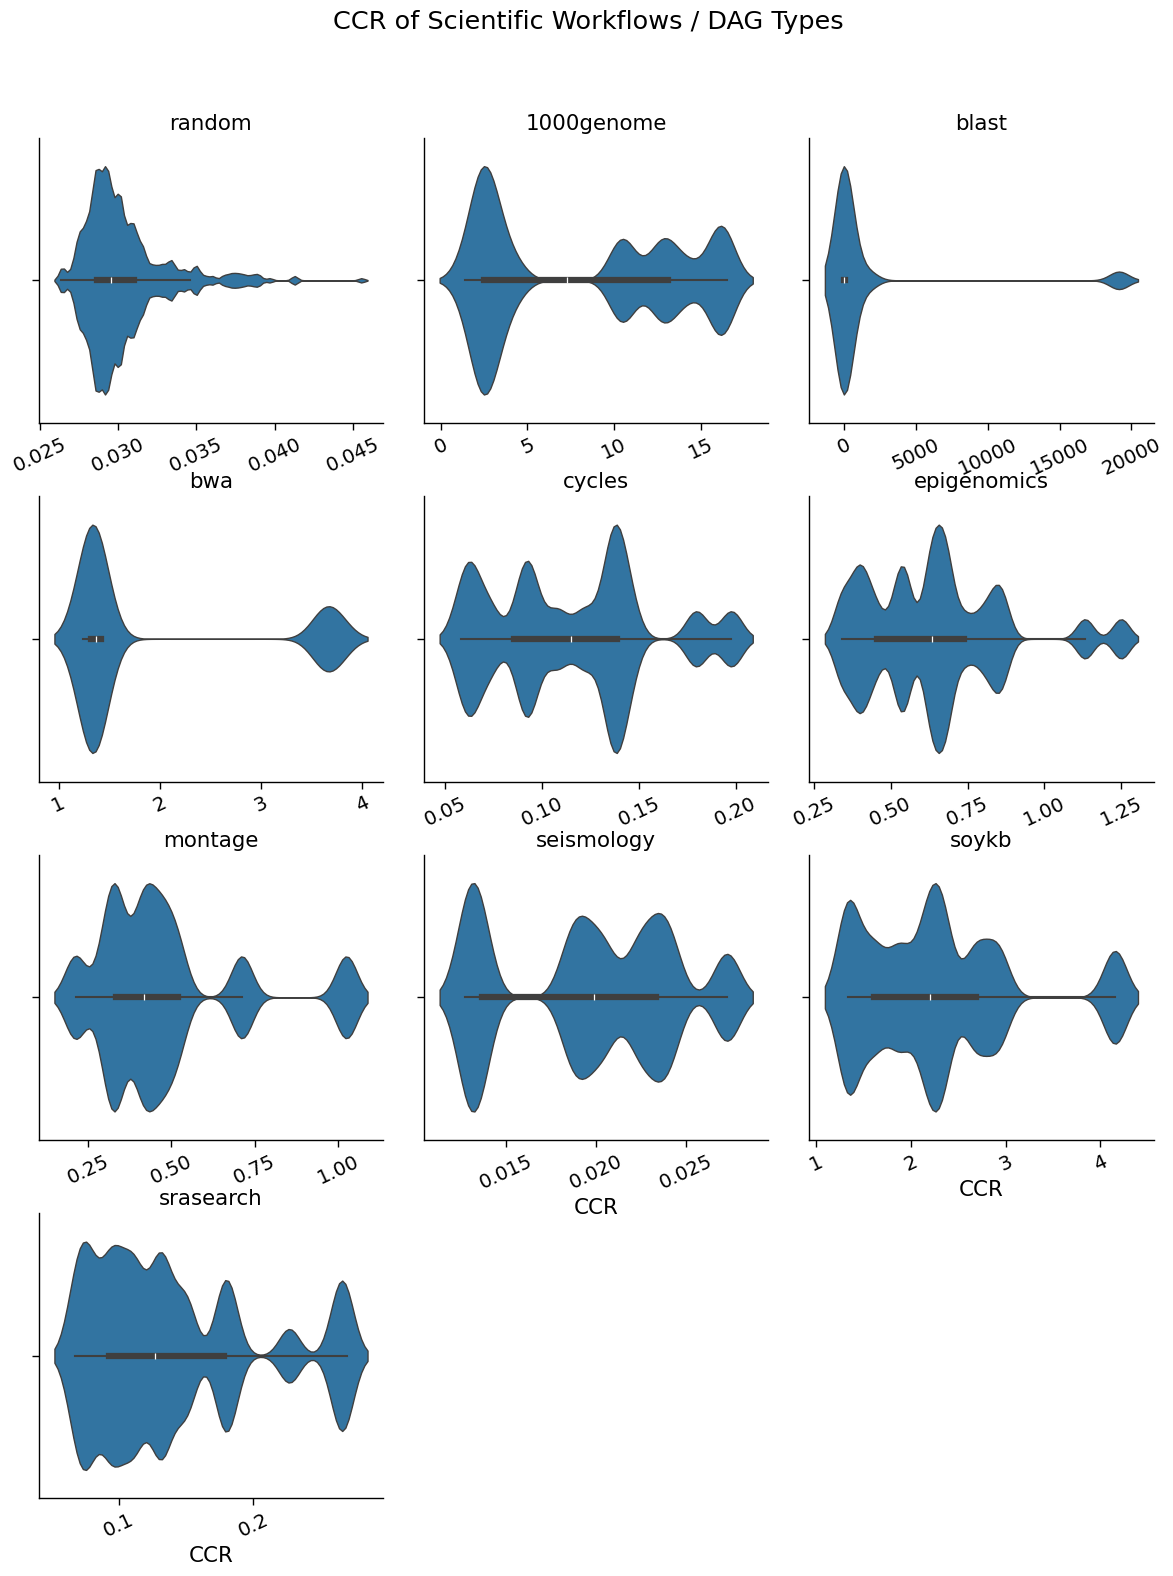

In [53]:

g = sns.FacetGrid(df, col="workflow", col_wrap=3, height=4, sharex=False)
g.map_dataframe(sns.violinplot, x="CCR",  orient='h')

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(25)  # or 45 for more angle

g.set_axis_labels("CCR", "")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("CCR of Scientific Workflows / DAG Types")


plt.show()


Or maybe also control for CCR

/tmp/ipykernel_26581/630172058.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipykernel_26581/630172058.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipykernel_26581/630172058.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipykernel_26581/630172058.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipykernel_26581/630172058.py:44: UserWarning: set_ticklabel

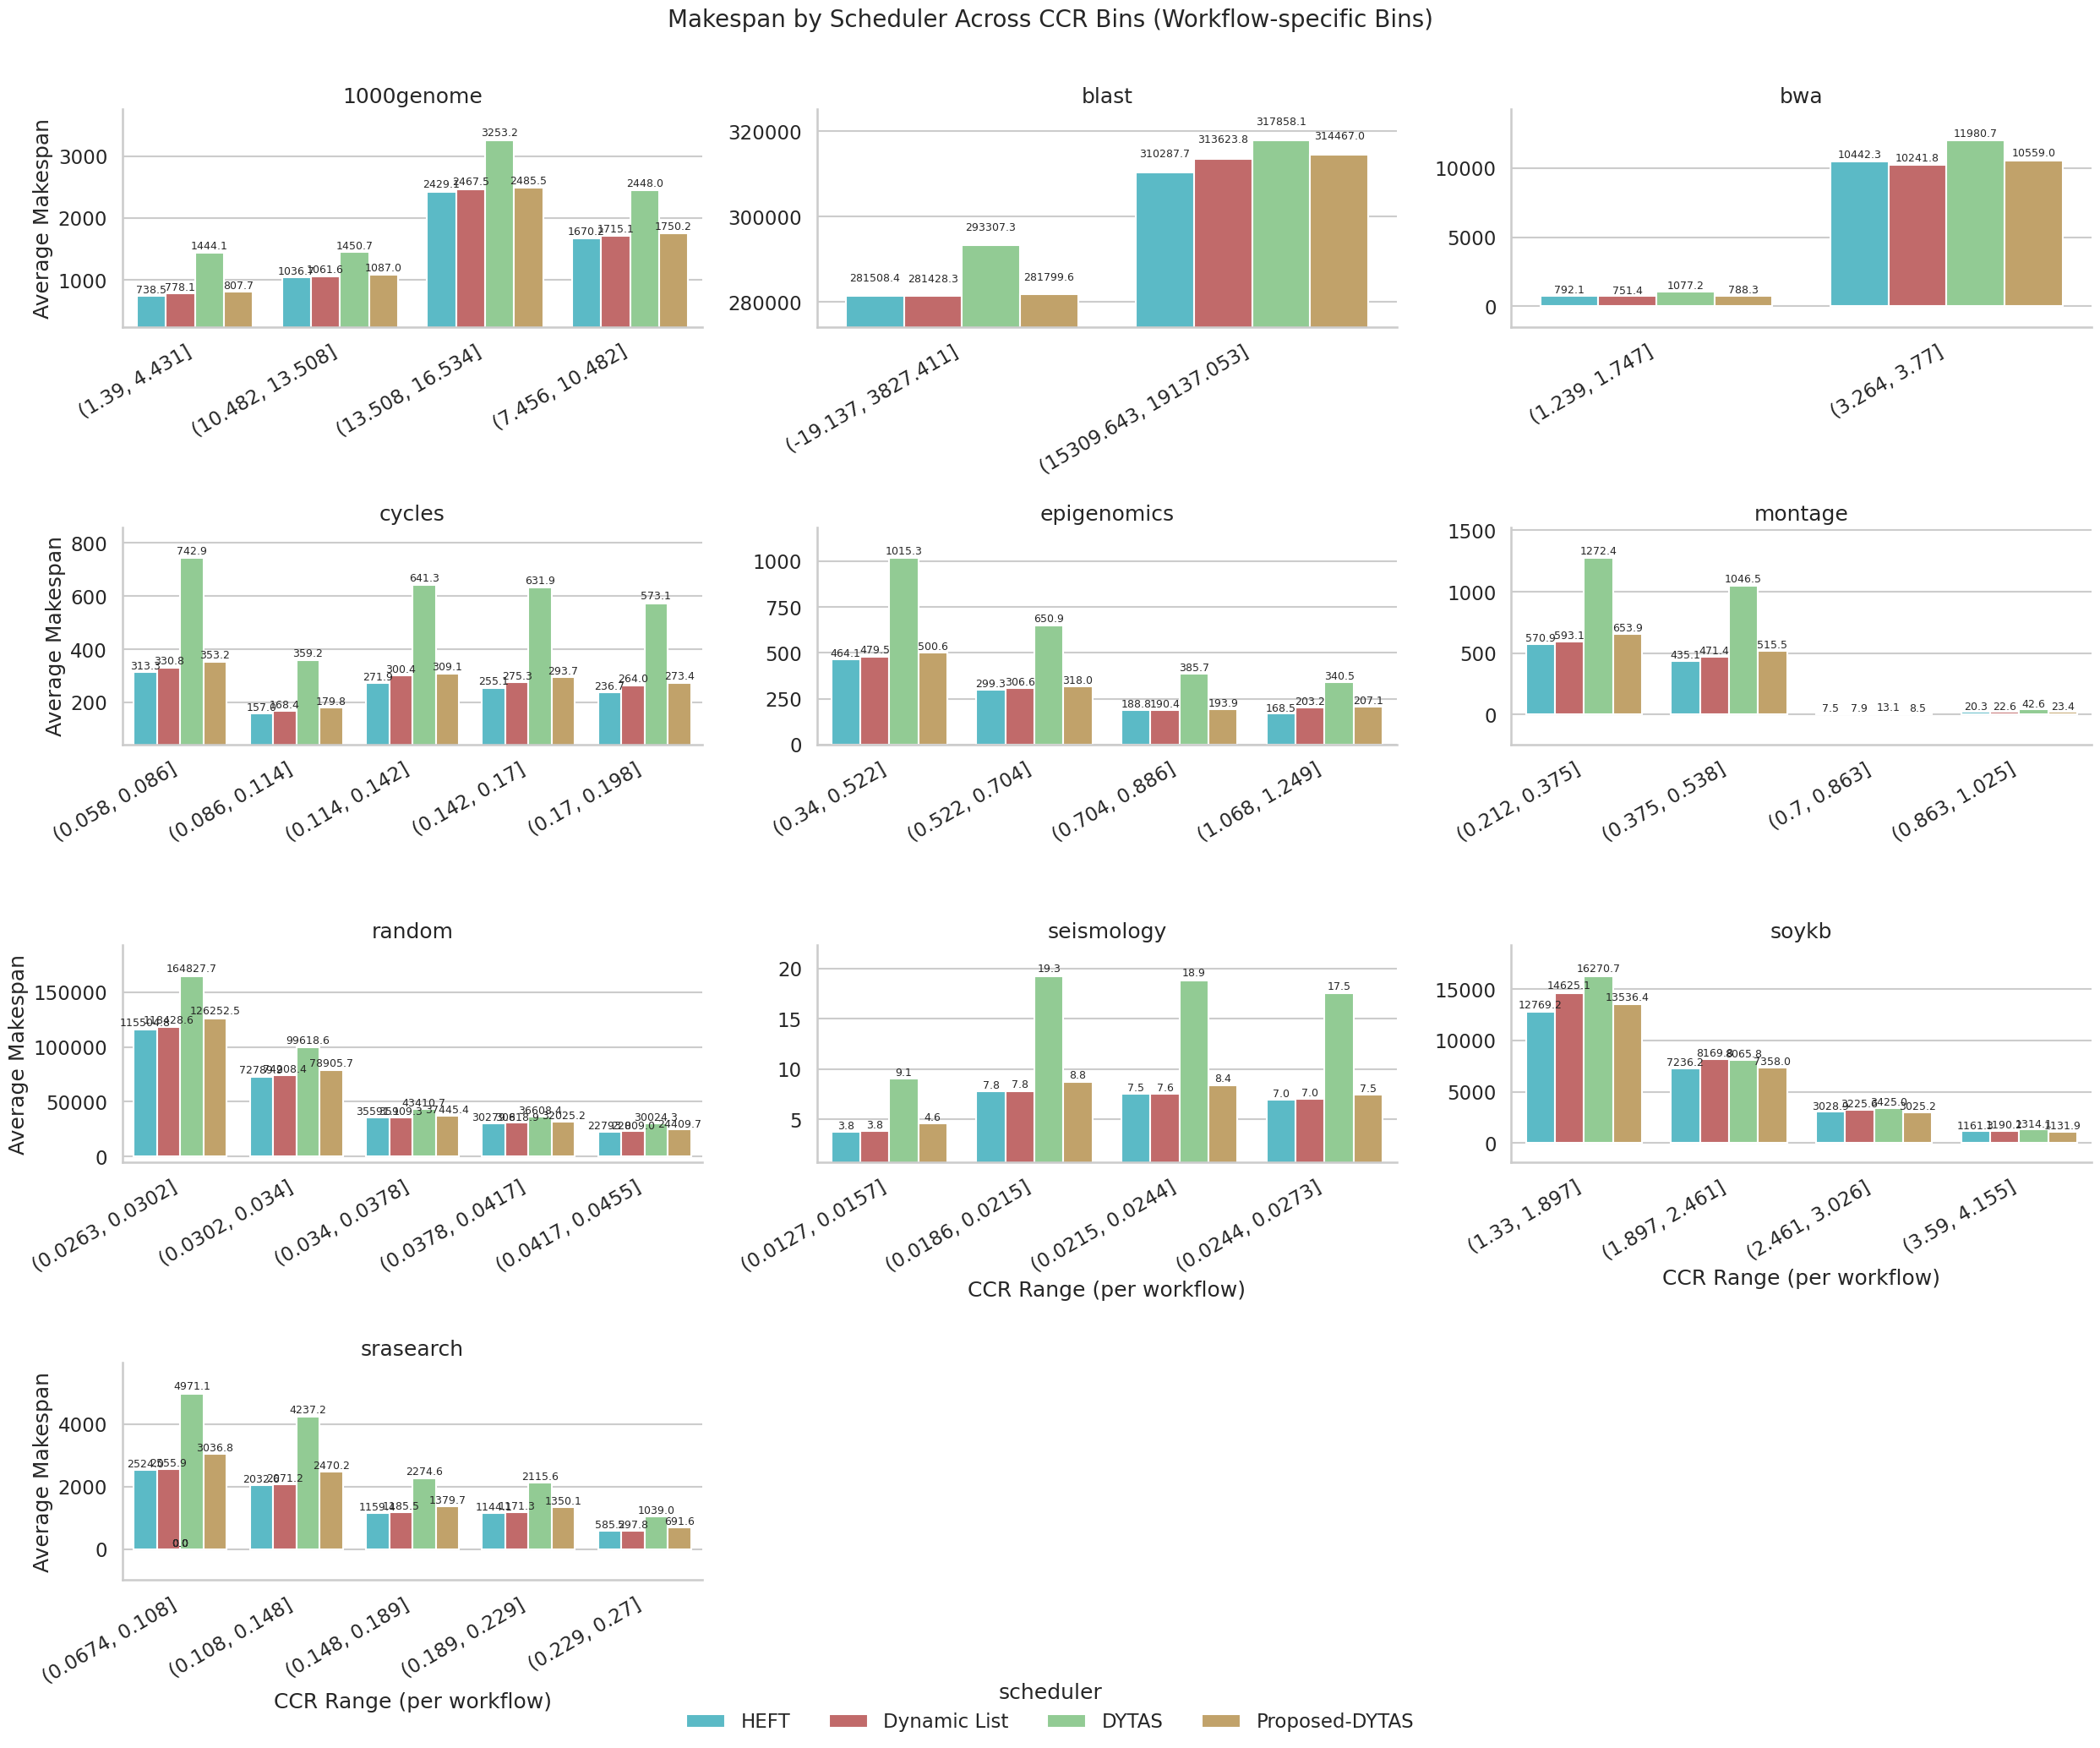

In [94]:
n_bins = 5  # Number of bins per workflow

# STEP 1: Bin CCR within each workflow
def bin_ccr_within_workflow(group):
    group = group.copy()
    group["CCR_bin"] = pd.cut(group["CCR"], bins=n_bins)
    return group

df_binned = df.groupby("workflow", group_keys=False)[list(df.columns)].apply(bin_ccr_within_workflow)

# STEP 2: Prepare the bins for plotting (optional: turn intervals into strings)
df_binned["CCR_bin"] = df_binned["CCR_bin"].astype(str)

# STEP 3: Aggregate average makespan per bin
grouped = (
    df_binned.groupby(["workflow", "scheduler", "CCR_bin"])["makespan"]
    .mean()
    .reset_index()
)

# STEP 4: Plot with Seaborn catplot
g = sns.catplot(
    data=grouped,
    x="CCR_bin", y="makespan",
    hue="scheduler",
    col="workflow",
    kind="bar",
    col_wrap=3,
    height=5,
    aspect=1.5,
    sharex=False,
    sharey=False,
    hue_order=hue_order, palette=cmap,
)

# STEP 5: Cleanup and styling
g.set_titles("{col_name}")
g.set_axis_labels("CCR Range (per workflow)", "Average Makespan")
# g.add_legend(title="Scheduler")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.05), ncol=4)


for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    bars = [bar.get_height() for bar in ax.patches]
    if not bars: continue  # skip empty plots
    min_val, max_val = min(bars), max(bars)
    margin = (max_val - min_val) * 0.2
    ax.set_ylim(min_val - margin, max_val + margin)

    for bar in ax.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01 * height,
            f"{height:.1f}",
            ha='center', va='bottom', fontsize=9
        )


g.figure.suptitle("Makespan by Scheduler Across CCR Bins (Workflow-specific Bins)", fontsize=20)

# Increase spacing to avoid overlap and give the title breathing room
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.92, bottom=0.05)

plt.show()


In [133]:
df.CCR.dtype

dtype('float64')

In [152]:
group = df.copy()
# Keep intervals as a categorical. The 'precision=2' makes bins display with 2 decimals.
group["CCR_bin"] = pd.cut(group["CCR"], bins=n_bins, precision=2).cat.as_ordered()

# group.reset_index(drop=True).CCR_bin.cat.as_ordered()

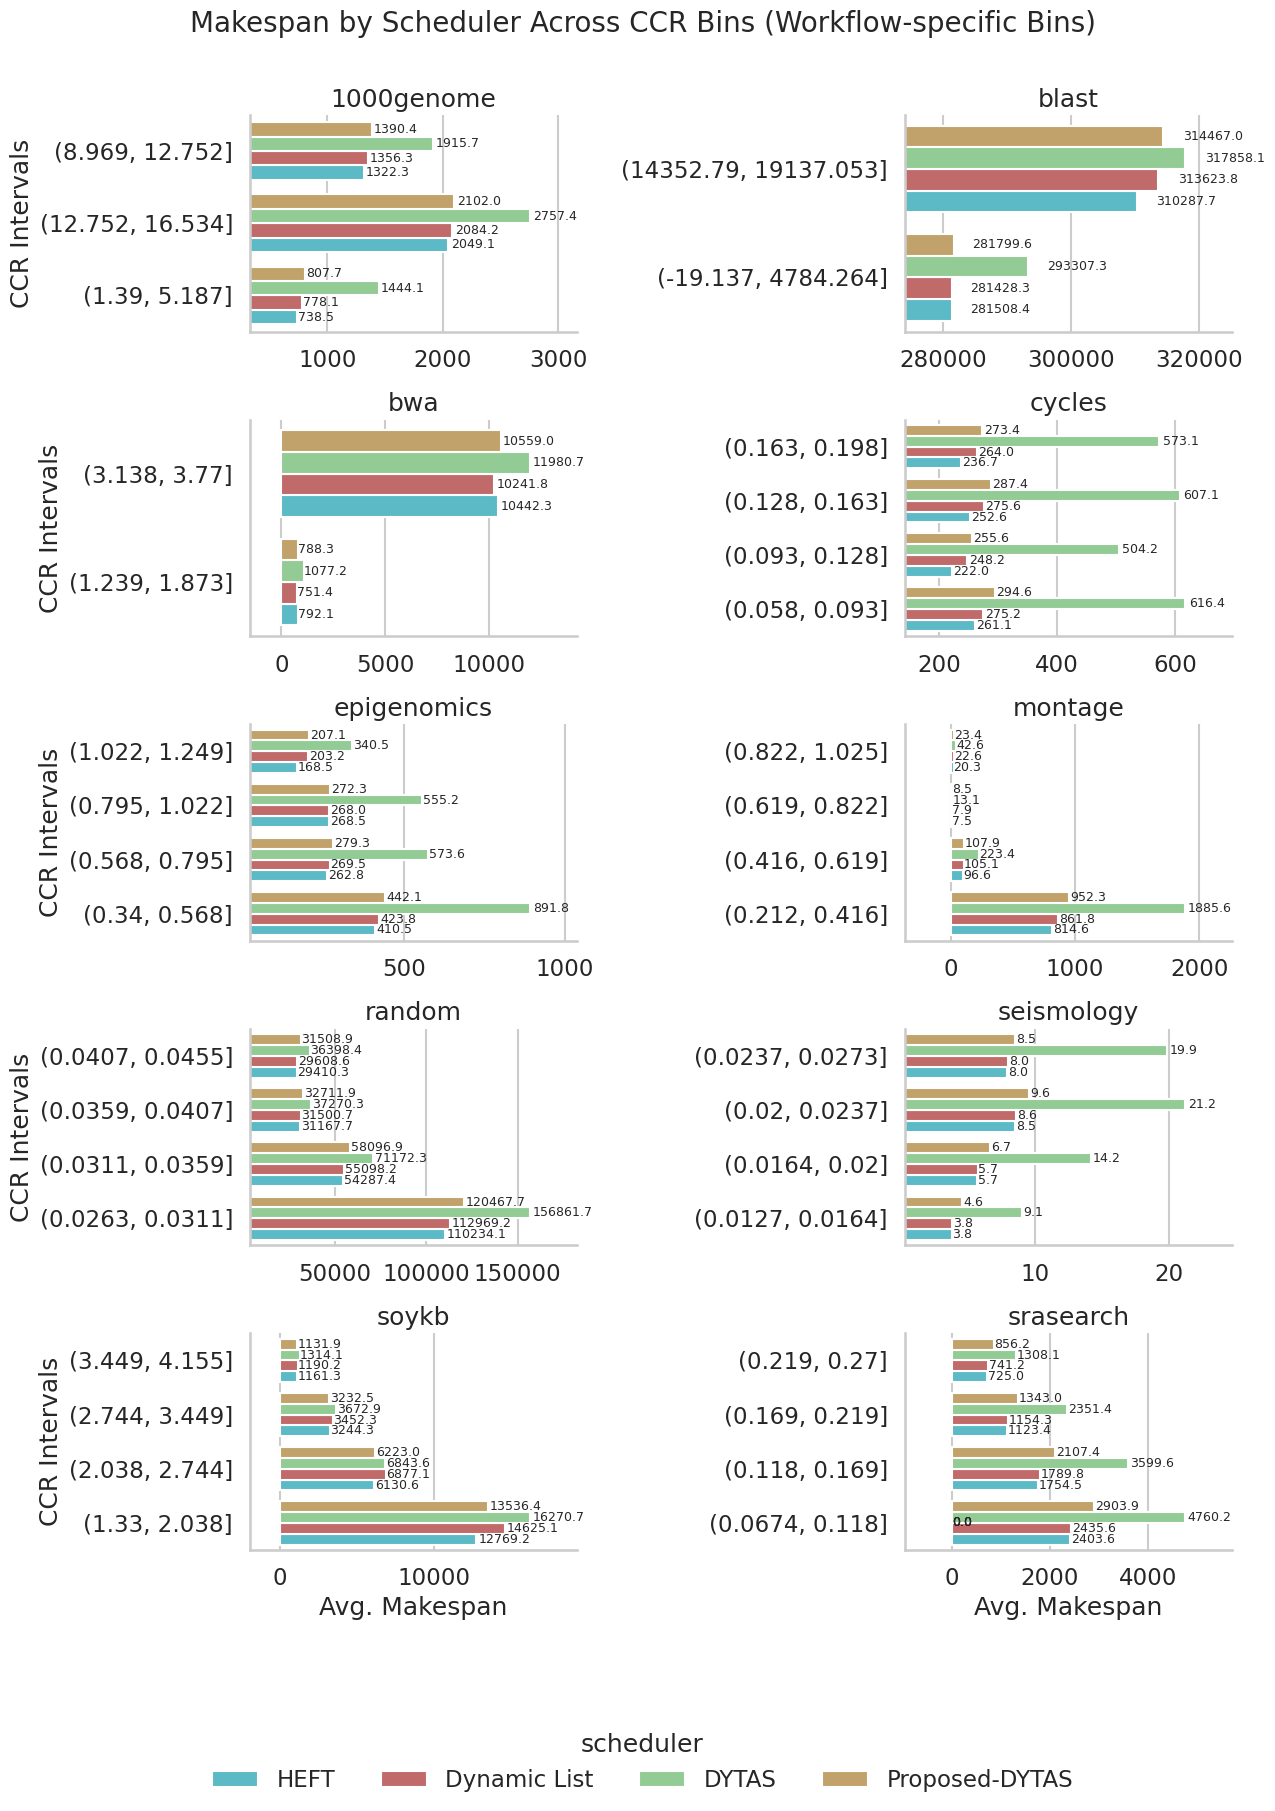

In [155]:
def bin_ccr_within_workflow(df, n_bins=4, ccr_col="CCR", workflow_col="workflow"):
    def _bin_within_group(group):
        group = group.copy()
        group["CCR_bin"] = pd.cut(group[ccr_col], bins=n_bins)
        return group
    
    # Group by workflow, apply binning
    df_binned = (
        df.groupby(workflow_col, group_keys=False)[list(df.columns)]
          .apply(_bin_within_group)
          .reset_index(drop=True)
    )
    # Optionally convert bin intervals to strings
    df_binned["CCR_bin"] = df_binned["CCR_bin"].astype(str)
    return df_binned

def compute_average_makespan(df_binned, group_cols=None, agg_col="makespan"):
    if group_cols is None:
        group_cols = ["workflow", "scheduler", "CCR_bin"]
    
    grouped = (
        df_binned.groupby(group_cols)[agg_col]
                .mean()
                .reset_index()
    )
    return grouped

def plot_makespan_by_bins(grouped_data, 
                          x_col="makespan", 
                          y_col="CCR_bin", 
                          hue_col="scheduler", 
                          col_col="workflow", 
                          hue_order=None, 
                          palette=None,
                          title="Makespan by Scheduler Across CCR Bins (Workflow-specific Bins)"):

    g = sns.catplot(
        data=grouped_data,
        y=y_col, x=x_col,
        hue=hue_col,
        col=col_col,
        kind="bar",
        col_wrap=2,
        height=3.5,
        aspect=1.5,
        sharex=False,
        sharey=False,
        hue_order=hue_order,
        palette=palette,
    )

    g.set_titles("{col_name}")
    g.set_axis_labels("Avg. Makespan", "CCR Intervals")

    # Move legend below
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    # Adjust axes, add annotations
    for ax in g.axes.flatten():
        bars = [bar.get_width() for bar in ax.patches]
        if not bars:
            continue
        min_val, max_val = min(bars), max(bars)
        margin = (max_val - min_val) * 0.2
        ax.set_xlim(min_val - margin, max_val + margin)

        # Add text annotations at the end of bars
        for bar in ax.patches:
            width = bar.get_width()
            ax.text(
                width + 0.01 * width,
                bar.get_y() + bar.get_height() / 2,
                f"{width:.1f}",
                ha='left', va='center', fontsize=9
            )
        
        ax.invert_yaxis()

    g.figure.suptitle(title, fontsize=20)
    g.figure.tight_layout()
    g.figure.subplots_adjust(top=0.92, bottom=0.10)

    return g

# === Example usage ===
# 1. Bin CCR
df_binned = bin_ccr_within_workflow(df, n_bins=4)

# 2. Compute average makespan per (workflow, scheduler, CCR_bin)
grouped = compute_average_makespan(df_binned)

# 3. Plot
g = plot_makespan_by_bins(
    grouped_data=grouped,
    hue_order=hue_order,
    palette=cmap
)

plt.show()


/tmp/ipykernel_26581/1570927425.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_binned = df.groupby('workflow', group_keys=False).apply(bin_ccr_for_workflow, n_bins=4)


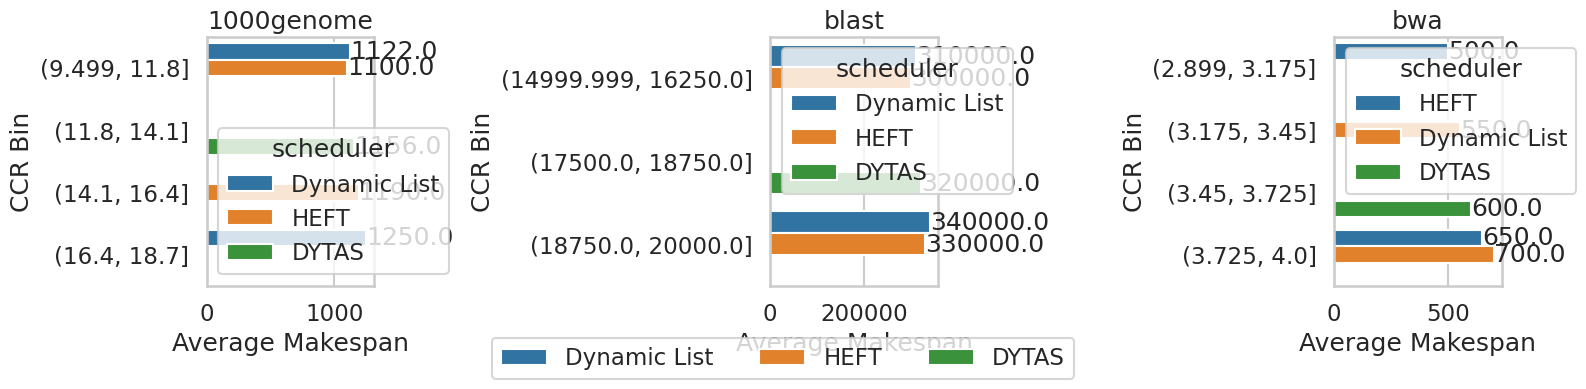

In [163]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. EXAMPLE DATA (replace with your own)
# -------------------------------------------------------------------
# data = {
#     'workflow': [
#         '1000genome','1000genome','1000genome','1000genome','1000genome',
#         'blast','blast','blast','blast','blast',
#         'bwa','bwa','bwa','bwa','bwa',
#         'bwa','bwa','bwa','bwa','bwa',
#     ],
#     'ccr': [
#         9.5, 11.3, 12.0, 15.2, 18.7,
#         15000, 16000, 18000, 19000, 20000,
#         2.9, 3.2, 3.5, 3.8, 4.0,
#         5.5, 6.2, 7.5, 8.8, 9.0
#     ],
#     'scheduler': [
#         'HEFT','Dynamic List','DYTAS','HEFT','Dynamic List',
#         'HEFT','Dynamic List','DYTAS','HEFT','Dynamic List',
#         'HEFT','Dynamic List','DYTAS','HEFT','Dynamic List',
#         'HEFT','Dynamic List','DYTAS','HEFT','Dynamic List',
#     ],
#     'makespan': [
#         1100, 1122, 1156, 1190, 1250,
#         300000, 310000, 320000, 330000, 340000,
#         500, 550, 600, 650, 700,
#         710, 720, 740, 800, 830
#     ]
# }

# df = pd.DataFrame(data)

# -------------------------------------------------------------------
# 2. BIN THE CCR FOR EACH WORKFLOW BASED ON THAT WORKFLOW'S MIN & MAX
# -------------------------------------------------------------------
def bin_ccr_for_workflow(group, n_bins=5):
    """
    Given a sub-dataframe (for one workflow), 
    create 'n_bins' intervals from min to max CCR.
    Returns the same group with a new 'ccr_bin' column.
    """
    ccr_min = group['ccr'].min()
    ccr_max = group['ccr'].max()

    # Make sure max > min to avoid zero-division
    # If ccr_min == ccr_max for some reason, you can handle that separately
    if ccr_min == ccr_max:
        # Just put everything in one bin
        bin_edges = [ccr_min, ccr_max]
    else:
        bin_edges = np.linspace(ccr_min, ccr_max, n_bins + 1)
    
    # Create the new bin column
    group['ccr_bin'] = pd.cut(group['ccr'], bins=bin_edges, include_lowest=True)
    return group

# Apply the function to each workflow group
df_binned = df.groupby('workflow', group_keys=False).apply(bin_ccr_for_workflow, n_bins=4)

# -------------------------------------------------------------------
# 3. COMPUTE THE AVERAGE MAKESPAN FOR (workflow, ccr_bin, scheduler)
# -------------------------------------------------------------------
df_avg = (
    df_binned
    .groupby(['workflow', 'ccr_bin', 'scheduler'], as_index=False)
    .agg(avg_makespan=('makespan', 'mean'))
)

# -------------------------------------------------------------------
# 4. PLOT A GRID OF HORIZONTAL BAR CHARTS (ONE PER WORKFLOW)
# -------------------------------------------------------------------
workflows = df_avg['workflow'].unique()
num_workflows = len(workflows)

# Adjust rows/cols for your data
cols = 3
rows = (num_workflows + cols - 1) // cols  # "ceiling" for the subplot layout

fig, axes = plt.subplots(
    nrows=rows,
    ncols=cols,
    figsize=(16, 4*rows),
    sharex=False,
    sharey=False
)
axes = axes.flatten()

for i, wf in enumerate(workflows):
    ax = axes[i]
    
    data_wf = df_avg[df_avg['workflow'] == wf].copy()
    
    # (Optional) control order of the CCR bins (ascending or descending)
    # ascending order for example:
    # If you do not set it, it might appear out of sequence
    data_wf['ccr_bin'] = data_wf['ccr_bin'].astype('category')
    data_wf['ccr_bin'] = data_wf['ccr_bin'].cat.as_ordered()
    
    sns.barplot(
        data=data_wf,
        x='avg_makespan',
        y='ccr_bin',
        hue='scheduler',
        orient='h',
        ax=ax
    )
    ax.set_title(wf)
    ax.set_xlabel('Average Makespan')
    ax.set_ylabel('CCR Bin')

    # Optionally label the bars with numeric values
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')

# Hide any unused subplots (if any)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Put the legend below or to the right, etc.
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(labels),
    bbox_to_anchor=(0.5, -0.02)
)

fig.tight_layout()
plt.show()


The above charts show how in most of the cases (except for seismology and blast) the lower the CCR (meaning the DAGs were more computationally heavy) the average makespan was longer than when the CCR was higher. In seismology we see the opposite of that, which I don't have at the moment a good reason as to why.

Nonetheless, the most important thing is to note how DYTAS in all of the cases showed very long avg. makespans, and it is more particularly noticeable in low CCR DAGs (tho we see the opposite in seismology).

/tmp/ipykernel_26581/1869921342.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_random_binned = df_random.groupby("dag_nodes", group_keys=False).apply(bin_ccr_within_size)
/tmp/ipykernel_26581/1869921342.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipykernel_26581/1869921342.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipykernel_26581/1869921342.py:46: UserWarning: set

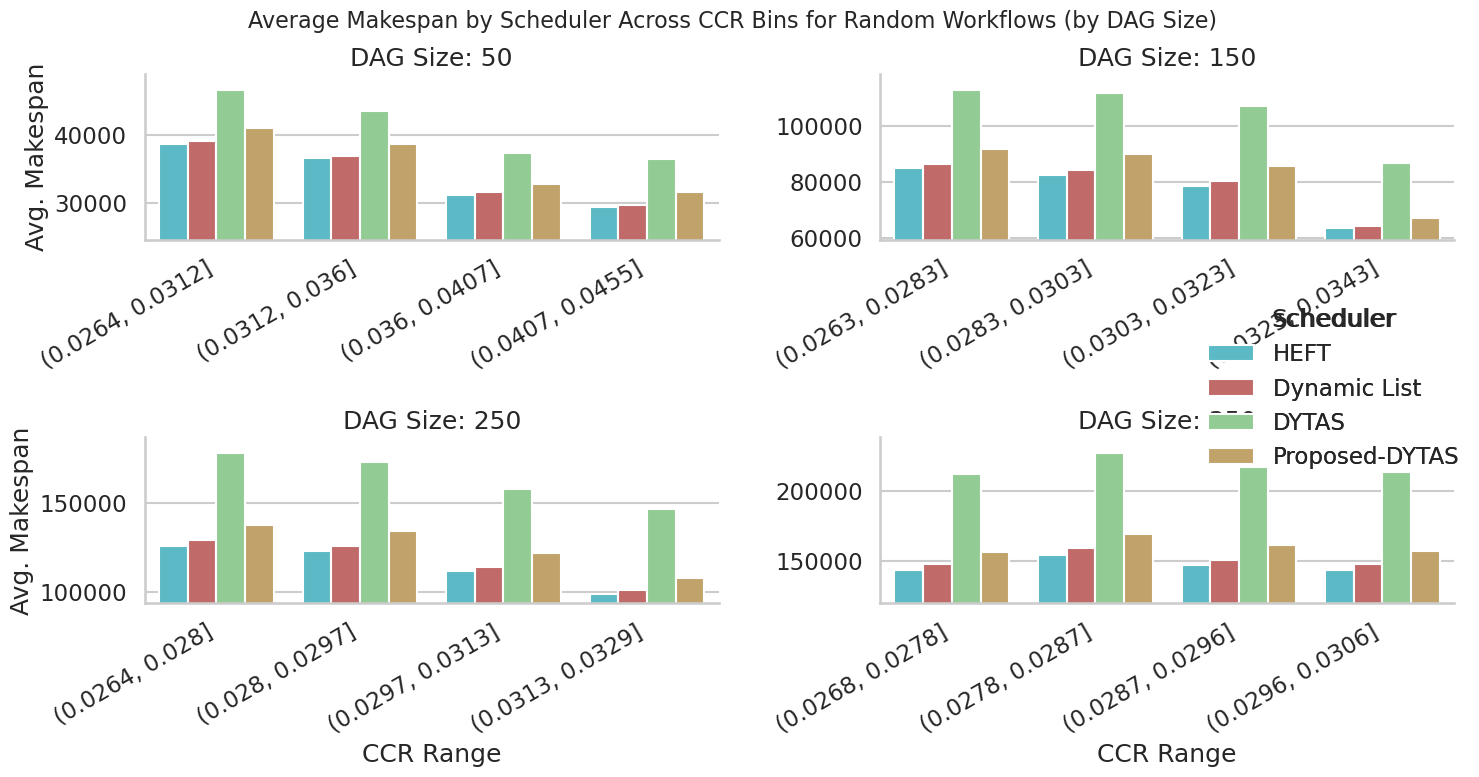

In [127]:
n_bins = 4  # Number of CCR bins per DAG size

# STEP 1: Filter for "random" workflows only
df_random = df[df["workflow"] == "random"].copy()

# STEP 2: Bin CCR within each DAG size group (i.e. dag_nodes)
def bin_ccr_within_size(group):
    group = group.copy()
    group["CCR_bin"] = pd.cut(group["CCR"], bins=n_bins)
    return group

df_random_binned = df_random.groupby("dag_nodes", group_keys=False).apply(bin_ccr_within_size)

# Optional: Convert intervals to string labels for cleaner x-axis
df_random_binned["CCR_bin"] = df_random_binned["CCR_bin"].astype(str)

# STEP 3: Group by DAG size, CCR bin, and scheduler to get avg makespan
grouped = (
    df_random_binned.groupby(["dag_nodes", "scheduler", "CCR_bin"])["makespan"]
    .mean()
    .reset_index()
)

# STEP 4: Plot each DAG size as a separate chart
g = sns.catplot(
    data=grouped,
    x="CCR_bin", y="makespan",
    hue="scheduler",
    col="dag_nodes",
    kind="bar",
    col_wrap=2,        # Adjust for layout
    height=4, 
    aspect=1.2,
    sharex=False,
    sharey=False,
    hue_order=hue_order, palette=cmap,
)

# STEP 5: Final cleanup
g.set_titles("DAG Size: {col_name}")
g.set_axis_labels("CCR Range", "Avg. Makespan")
g.add_legend(title="Scheduler")

# Rotate x-axis tick labels for clarity
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    y_max = ax.get_ylim()[1]
    y_min = ax.get_ylim()[0]
    zoom_start = y_min + (y_max - y_min) * 0.5
    ax.set_ylim(zoom_start, y_max)

g.figure.suptitle("Average Makespan by Scheduler Across CCR Bins for Random Workflows (by DAG Size)", fontsize=16)
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.9)

plt.show()


# Comparing Heterogeneous vs Homogeneous systems
To answer my hypothesis.

# Pairwise Rank

# Non-Parametric Testing

# Kruskal-Wallis

In [173]:
# Re-freshing the dataframe
df = pd.read_pickle("./data/pre-processed-metrics-dataframe.pkl")

In [174]:
def calculate_kruskal_wallis(df, metric):
    grouped_data = [group[metric].values for _, group in df.groupby('scheduler')]
    statistic, p_value = stats.kruskal(*grouped_data)
    return (statistic, p_value)
    

In [175]:
calculate_kruskal_wallis(df, "makespan")

(60126.34715862171, 0.0)

In [177]:
calculate_kruskal_wallis(df, "SLR")

(505201.6360009387, 0.0)

In [178]:
calculate_kruskal_wallis(df, "speedup")

(320823.7591449945, 0.0)

In [179]:
calculate_kruskal_wallis(df, "efficiency_cores")

(74174.13622048068, 0.0)

In [180]:
calculate_kruskal_wallis(df, "efficiency_processors")

(177896.40647861257, 0.0)

## Now do kruskal-wallis controlloing for Homogeneous, Heterogeneous and Single Core systems

# Dunn's Post-hoc tests

# Random Forrest Regression